# Analyzing the forecastings

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

## Reading data

In [2]:
df = pd.read_csv('../data/input/df_ts_epidemic_episodes.csv', index_col=0)
df.DATA = pd.to_datetime(df.DATA)

In [3]:
df = df.sort_values(by=['CODIGO_MUNICIPIO_6', 'DATA'])

In [4]:
df_results_sirds = pd.read_csv('sirds/data/df_deaths_forecasted_mean.csv')
df_results_sirds['max_date_to_fit'] = pd.to_datetime(df_results_sirds['max_date_to_fit'])
df_results_sirds['date'] = pd.to_datetime(df_results_sirds['date'], format='mixed')

In [5]:
df_results_lstm = pd.read_csv('lstm/data/df_forecasting_mean.csv')
df_results_lstm['max_date_to_fit'] = pd.to_datetime(df_results_lstm['max_date_to_fit'])
df_results_lstm['date'] = pd.to_datetime(df_results_lstm['date'], format='mixed')
df_results_lstm = df_results_lstm.rename(columns={'execution': 'estimation'})

In [6]:
df_results_sirds_hybrid = pd.read_csv('sirds_hybrid/data/df_deaths_forecasted_mean.csv')
df_results_sirds_hybrid['max_date_to_fit'] = pd.to_datetime(df_results_sirds_hybrid['max_date_to_fit'])
df_results_sirds_hybrid['date'] = pd.to_datetime(df_results_sirds_hybrid['date'], format='mixed')

In [7]:
df_results_ensemble = pd.read_csv('ensemble_simple/data/df_forecasting_mean.csv')
df_results_ensemble['max_date_to_fit'] = pd.to_datetime(df_results_ensemble['max_date_to_fit'])
df_results_ensemble['date'] = pd.to_datetime(df_results_ensemble['date'], format='mixed')

In [8]:
EPSILON = 0.00001

### Data for confidence interval analysis

In [9]:
df_confidence_interval_sirds = pd.read_csv('sirds/data/df_forecast_death_confidence_interval.csv')
df_confidence_interval_sirds['max_date_to_fit'] = pd.to_datetime(df_confidence_interval_sirds['max_date_to_fit'])
df_confidence_interval_sirds['date'] = pd.to_datetime(df_confidence_interval_sirds['date'])

In [10]:
df_confidence_interval_lstm = pd.read_csv('lstm/data/df_forecast_death_confidence_interval.csv')
df_confidence_interval_lstm['max_date_to_fit'] = pd.to_datetime(df_confidence_interval_lstm['max_date_to_fit'])
df_confidence_interval_lstm['date'] = pd.to_datetime(df_confidence_interval_lstm['date'])

In [11]:
df_confidence_interval_sirds_hybrid = pd.read_csv('sirds_hybrid/data/df_forecast_death_confidence_interval.csv')
df_confidence_interval_sirds_hybrid['max_date_to_fit'] = pd.to_datetime(df_confidence_interval_sirds_hybrid['max_date_to_fit'])
df_confidence_interval_sirds_hybrid['date'] = pd.to_datetime(df_confidence_interval_sirds_hybrid['date'])

## Calculating measurements

In [12]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    data_range = np.max(y_true) - np.min(y_true)
    nrmse = rmse / data_range
    return nrmse

In [13]:
df_measurements = pd.DataFrame()

for model_name, df_model_output in zip(['SIRDS','LSTM', 'Hybrid SIRDS'], [df_results_sirds, df_results_lstm, df_results_sirds_hybrid]):
    df_model_output = df_model_output.sort_values(['municipality', 'date'])
    for max_date_to_fit in df_model_output['max_date_to_fit'].unique():
        list_municipality = []
        list_week = []
        list_sse = []
        list_r2 = []
        list_mape = []
        list_nrmse = []
        df_results_moment = df_model_output.loc[(df_model_output['max_date_to_fit'] == max_date_to_fit)]
        for id_municipality in df_results_moment['municipality_id'].unique()[:]:        
            df_results_municipality = df_results_moment.loc[(df_results_moment['municipality_id'] == id_municipality)]
            model_new_deaths = df_results_municipality['forecast'].values
            municipality = df_results_municipality['municipality'].iloc[0]
            max_date_predicted = df_results_municipality['date'].max()
            
            df_municipality = df[(df.CODIGO_MUNICIPIO_6 == id_municipality)].copy().reset_index(drop=True)
            df_temp = df_municipality[(df_municipality.DATA > max_date_to_fit) & (df_municipality.DATA <= max_date_predicted)]
            real_new_deaths = df_temp.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.values
               
            real_new_deaths_forecasting = real_new_deaths
            model_new_deaths_forecasting = model_new_deaths
                                               
            sse = mean_squared_error(model_new_deaths_forecasting, real_new_deaths_forecasting)        
            r2 = r2_score(model_new_deaths_forecasting, real_new_deaths_forecasting)
            mape = np.mean(np.abs((real_new_deaths_forecasting - model_new_deaths_forecasting) / (real_new_deaths_forecasting + EPSILON))) * 100
            nrmse = calculate_nrmse(real_new_deaths_forecasting, model_new_deaths_forecasting)
            
            list_municipality.append(municipality)
            list_week.append('all')
            list_sse.append(sse)
            list_r2.append(r2)
            list_mape.append(mape)
            list_nrmse.append(nrmse)
            
            for week in range(int(len(model_new_deaths)/7)):
                begin = week * 7
                end = (week+1) * 7 
                
                model_new_deaths_forecasting = model_new_deaths[begin:end]
                real_new_deaths_forecasting = real_new_deaths[begin:end]
            
                sse = mean_squared_error(model_new_deaths_forecasting, real_new_deaths_forecasting)        
                r2 = r2_score(model_new_deaths_forecasting, real_new_deaths_forecasting)
                mape = np.mean(np.abs((real_new_deaths_forecasting - model_new_deaths_forecasting) / (real_new_deaths_forecasting + EPSILON))) * 100
                nrmse = calculate_nrmse(real_new_deaths_forecasting, model_new_deaths_forecasting)
            
                list_municipality.append(municipality)
                list_week.append(str(week+1))
                list_sse.append(sse)
                list_r2.append(r2)
                list_mape.append(mape)
                list_nrmse.append(nrmse)
        
        df_measurements_moment = pd.DataFrame({'municipality': list_municipality, 'week': list_week, 'sse': list_sse, 'r2': list_r2, 'mape': list_mape, 'nrmse': list_nrmse})
        df_measurements_moment['max_date_to_fit'] = max_date_to_fit
        df_measurements_moment['model_name'] = model_name
        df_measurements = pd.concat([df_measurements, df_measurements_moment])

<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-12-d79b3c78bd67>:7: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / data_range
<ipython-input-1

In [14]:
df_results_municipality

,Unnamed: 0,municipality,municipality_id,max_date_to_fit,date,forecast
30072,30072,Uberlândia,317020.0,2020-04-25,2020-04-26,0.007491
30073,30073,Uberlândia,317020.0,2020-04-25,2020-04-27,0.006943
30074,30074,Uberlândia,317020.0,2020-04-25,2020-04-28,0.006594
30075,30075,Uberlândia,317020.0,2020-04-25,2020-04-29,0.006258
30076,30076,Uberlândia,317020.0,2020-04-25,2020-04-30,0.005937
...,...,...,...,...,...,...
30151,30151,Uberlândia,317020.0,2020-04-25,2020-07-14,0.000120
30152,30152,Uberlândia,317020.0,2020-04-25,2020-07-15,0.000114
30153,30153,Uberlândia,317020.0,2020-04-25,2020-07-16,0.000108
30154,30154,Uberlândia,317020.0,2020-04-25,2020-07-17,0.000103


In [15]:
model_name

'Hybrid SIRDS'

In [16]:
df_measurements[df_measurements['week'] == 'all'].groupby(['max_date_to_fit','model_name']).describe().round(2)

sse                                        \
                             count   mean    std   min   25%   50%   75%   
max_date_to_fit model_name                                                 
2020-04-25      Hybrid SIRDS  39.0   1.09   1.33  0.01  0.11  0.76  1.54   
                LSTM          41.0   1.63   3.17  0.00  0.01  0.08  1.54   
                SIRDS         39.0  11.54  29.64  0.01  0.12  0.99  7.20   
2020-07-18      Hybrid SIRDS  41.0   1.05   3.89  0.01  0.05  0.23  0.68   
                LSTM          41.0   0.12   0.23  0.01  0.03  0.07  0.13   
                SIRDS         41.0   1.49   5.68  0.00  0.02  0.05  0.21   
2020-10-10      Hybrid SIRDS  41.0   0.15   0.28  0.00  0.02  0.06  0.18   
                LSTM          41.0   0.03   0.03  0.00  0.01  0.02  0.04   
                SIRDS         41.0   0.24   0.65  0.00  0.02  0.04  0.12   
2021-01-02      Hybrid SIRDS  41.0   0.90   1.71  0.03  0.18  0.47  0.87   
                LSTM          41.0   0.89   1.55  0.03  0.21  0.40  0.84   
                SIRDS         41.0   0.80   1.62  0.04  0.21  0.39  0.78   
2021-03-27      Hybrid SIRDS  41.0   0.39   0.34  0.03  0.16  0.28  0.49   
                LSTM          41.0   0.33   0.29  0.01  0.11  0.24  0.46   
                SIRDS         41.0   0.87   1.48  0.02  0.13  0.43  0.77   
2021-06-19      Hybrid SIRDS  41.0   0.10   0.09  0.00  0.04  0.09  0.13   
                LSTM          41.0   0.07   0.08  0.00  0.02  0.04  0.08   
                SIRDS         41.0   0.19   0.21  0.02  0.05  0.12  0.28   
2021-09-11      Hybrid SIRDS  41.0   0.21   0.21  0.02  0.09  0.14  0.25   
                LSTM          41.0   0.18   0.28  0.01  0.05  0.09  0.14   
                SIRDS         41.0   0.37   1.20  0.00  0.02  0.07  0.24   
2021-12-04      Hybrid SIRDS  41.0   0.30   0.73  0.02  0.04  0.07  0.21   
                LSTM          41.0   0.04   0.02  0.01  0.02  0.03  0.05   
                SIRDS         41.0   0.10   0.16  0.01  0.04  0.06  0.10   
2022-02-26      Hybrid SIRDS  41.0   0.03   0.02  0.01  0.01  0.02  0.03   
                LSTM          41.0   0.15   0.06  0.07  0.11  0.15  0.18   
                SIRDS         41.0   0.06   0.18  0.00  0.00  0.00  0.01   

                                        r2                ...        mape  \
                                 max count          mean  ...         75%   
max_date_to_fit model_name                                ...               
2020-04-25      Hybrid SIRDS    6.72  39.0 -2.236860e+05  ...       99.95   
                LSTM           15.22  41.0 -1.808137e+05  ...       99.87   
                SIRDS         165.86  39.0 -3.032743e+08  ...      842.22   
2020-07-18      Hybrid SIRDS   25.11  41.0 -2.282000e+01  ...      308.63   
                LSTM            1.45  41.0 -1.780000e+01  ...       95.69   
                SIRDS          33.85  41.0 -4.723000e+01  ...      193.39   
2020-10-10      Hybrid SIRDS    1.69  41.0 -1.713800e+02  ...      124.03   
                LSTM            0.12  41.0 -4.393000e+01  ...      112.75   
                SIRDS           3.99  41.0 -1.512000e+02  ...      124.34   
2021-01-02      Hybrid SIRDS   10.73  41.0 -1.534340e+03  ...       50.63   
                LSTM            9.15  41.0 -2.055410e+03  ...       47.46   
                SIRDS          10.34  41.0 -3.848100e+02  ...       55.02   
2021-03-27      Hybrid SIRDS    1.68  41.0 -2.530000e+00  ...       49.06   
                LSTM            1.01  41.0 -2.200000e+00  ...       45.80   
                SIRDS           6.78  41.0 -4.340000e+00  ...       60.21   
2021-06-19      Hybrid SIRDS    0.45  41.0 -1.491000e+01  ...      305.37   
                LSTM            0.32  41.0 -6.820000e+00  ...      202.36   
                SIRDS           0.86  41.0 -1.017500e+02  ...      349.76   
2021-09-11      Hybrid SIRDS    0.88  41.0 -3.239000e+01  ...    64709.77   
                LSTM            1.55  41.0 -2.119000e+01

In [17]:
df_measurements[['max_date_to_fit','r2','week','model_name']].groupby(['max_date_to_fit','week','model_name']).describe().round(2)

r2                              \
                                  count          mean           std   
max_date_to_fit week model_name                                       
2020-04-25      1    Hybrid SIRDS  39.0 -1.277157e+05  2.061236e+05   
                     LSTM          41.0 -6.357255e+05  1.409546e+06   
                     SIRDS         39.0 -4.101942e+08  2.549671e+09   
                10   Hybrid SIRDS  39.0 -9.497498e+09  1.279515e+10   
                     SIRDS         39.0 -1.640726e+11  1.022502e+12   
...                                 ...           ...           ...   
2022-02-26      9    LSTM          41.0 -2.265569e+04  4.072545e+04   
                     SIRDS         41.0 -2.511131e+04  4.325962e+04   
                all  Hybrid SIRDS  41.0 -4.926400e+02  2.035520e+03   
                     LSTM          41.0 -2.252000e+01  2.623000e+01   
                     SIRDS         41.0 -8.340000e+00  1.791000e+01   

                                                                             \
                                            min           25%           50%   
max_date_to_fit week model_name                                               
2020-04-25      1    Hybrid SIRDS -8.585924e+05 -1.629971e+05 -1.716974e+04   
                     LSTM         -6.434257e+06 -2.660275e+05 -6.437320e+03   
                     SIRDS        -1.592449e+10 -3.059500e+02 -1.625000e+01   
                10   Hybrid SIRDS -5.162271e+10 -1.388739e+10 -5.747320e+09   
                     SIRDS        -6.385859e+12 -1.508340e+03 -3.102200e+02   
...                                         ...           ...           ...   
2022-02-26      9    LSTM         -1.739349e+05 -1.549439e+04 -5.154560e+03   
                     SIRDS        -1.925876e+05 -3.204249e+04 -2.187540e+03   
                all  Hybrid SIRDS -1.303305e+04 -1.216500e+02 -1.555000e+01   
                     LSTM         -1.545300e+02 -1.731000e+01 -1.418000e+01   
                     SIRDS        -8.168000e+01 -5.490000e+00 -2.200000e-01   

                                                              
                                            75%          max  
max_date_to_fit week model_name                               
2020-04-25      1    Hybrid SIRDS -4.269790e+03      -131.59  
                     LSTM         -9.050400e+02       -27.14  
                     SIRDS        -3.240000e+00         0.84  
                10   Hybrid SIRDS -4.737031e+08 -15830554.36  
                     SIRDS        -5.638000e+01        -0.88  
...                                         ...          ...  
2022-02-26      9    LSTM         -2.306940e+03      -714.98  
                     SIRDS        -5.709600e+02        -3.71  
                all  Hybrid SIRDS -5.120000e+00         0.12  
                     LSTM         -1.128000e+01        -5.62  
                     SIRDS         4.100000e-01         0.85  

[327 rows x 8 columns]

In [18]:
df_measurements[['max_date_to_fit','sse','week','model_name']].groupby(['max_date_to_fit','week','model_name']).describe().round(2)

sse                                       \
                                  count  mean    std   min   25%   50%   75%   
max_date_to_fit week model_name                                                
2020-04-25      1    Hybrid SIRDS  39.0  1.23   2.67  0.00  0.00  0.02  0.63   
                     LSTM          41.0  1.17   2.61  0.00  0.00  0.01  0.48   
                     SIRDS         39.0  0.05   0.11  0.00  0.00  0.01  0.06   
                10   Hybrid SIRDS  39.0  0.71   1.09  0.02  0.16  0.30  0.74   
                     SIRDS         39.0  7.88  17.52  0.00  0.11  0.56  8.23   
...                                 ...   ...    ...   ...   ...   ...   ...   
2022-02-26      9    LSTM          41.0  0.22   0.07  0.10  0.16  0.21  0.24   
                     SIRDS         41.0  0.08   0.24  0.00  0.00  0.00  0.01   
                all  Hybrid SIRDS  41.0  0.03   0.02  0.01  0.01  0.02  0.03   
                     LSTM          41.0  0.15   0.06  0.07  0.11  0.15  0.18   
                     SIRDS         41.0  0.06   0.18  0.00  0.00  0.00  0.01   

                                          
                                     max  
max_date_to_fit week model_name           
2020-04-25      1    Hybrid SIRDS  11.75  
                     LSTM          11.76  
                     SIRDS          0.61  
                10   Hybrid SIRDS   4.39  
                     SIRDS         85.53  
...                                  ...  
2022-02-26      9    LSTM           0.49  
                     SIRDS          1.05  
                all  Hybrid SIRDS   0.12  
                     LSTM           0.38  
                     SIRDS          0.80  

[327 rows x 8 columns]

In [19]:
df_measurements[df_measurements['mape']!=np.inf][['max_date_to_fit','mape','week','model_name']].groupby(['max_date_to_fit','week','model_name']).describe().round(2)

mape                                  \
                                  count        mean         std     min   
max_date_to_fit week model_name                                           
2020-04-25      1    Hybrid SIRDS  39.0     3533.00    13268.90   69.24   
                     LSTM          41.0     5848.87    17816.89   70.17   
                     SIRDS         39.0     7857.72    40400.87    4.67   
                10   Hybrid SIRDS  39.0       99.95        0.13   99.23   
                     SIRDS         39.0      391.88      675.74    3.01   
...                                 ...         ...         ...     ...   
2022-02-26      9    LSTM          41.0  2222617.27  2109797.83  509.51   
                     SIRDS         41.0   622049.86  1498545.28   16.89   
                all  Hybrid SIRDS  41.0   475240.35   447445.52  119.52   
                     LSTM          41.0  1284173.58   945506.03  438.83   
                     SIRDS         41.0   375114.38   723238.10   45.13   

                                                                      \
                                         25%         50%         75%   
max_date_to_fit week model_name                                        
2020-04-25      1    Hybrid SIRDS      86.72       98.60       99.50   
                     LSTM              86.60       98.65       99.62   
                     SIRDS             18.26       34.41       95.99   
                10   Hybrid SIRDS      99.96       99.99       99.99   
                     SIRDS             66.80      118.56      373.08   
...                                      ...         ...         ...   
2022-02-26      9    LSTM            4166.28  1668401.88  4047596.09   
                     SIRDS           1221.01   160509.27   532489.40   
                all  Hybrid SIRDS  158223.17   441770.10   652593.00   
                     LSTM          327919.41  1169967.34  2150685.97   
                     SIRDS          54820.24   124727.54   313929.44   

                                               
                                          max  
max_date_to_fit week model_name                
2020-04-25      1    Hybrid SIRDS    62299.29  
                     LSTM            70145.40  
                     SIRDS          247356.31  
                10   Hybrid SIRDS      100.00  
                     SIRDS            3567.51  
...                                       ...  
2022-02-26      9    LSTM          7030494.04  
                     SIRDS         8822942.70  
                all  Hybrid SIRDS  2492668.58  
                     LSTM          3512632.63  
                     SIRDS         4023763.06  

[327 rows x 8 columns]

## Show boxplots

In [20]:
df_measurements.columns

Index(['municipality', 'week', 'sse', 'r2', 'mape', 'nrmse', 'max_date_to_fit',
       'model_name'],
      dtype='object')

In [21]:
df_measurements_chart = df_measurements.copy()
df_measurements_chart.loc[df_measurements_chart['week']=='all', 'week'] = 13
df_measurements_chart['week'] = df_measurements_chart['week'].astype(int)
df_measurements_chart = df_measurements_chart.sort_values(by=['max_date_to_fit','model_name'])

### MAPE

In [22]:
df_measurements_chart.loc[df_measurements_chart['model_name']=='SIRDS', 'model_order'] = 0
df_measurements_chart.loc[df_measurements_chart['model_name']=='LSTM', 'model_order'] = 1
df_measurements_chart.loc[df_measurements_chart['model_name']=='Hybrid SIRDS', 'model_order'] = 4
df_measurements_chart = df_measurements_chart.sort_values(['max_date_to_fit','model_order'])

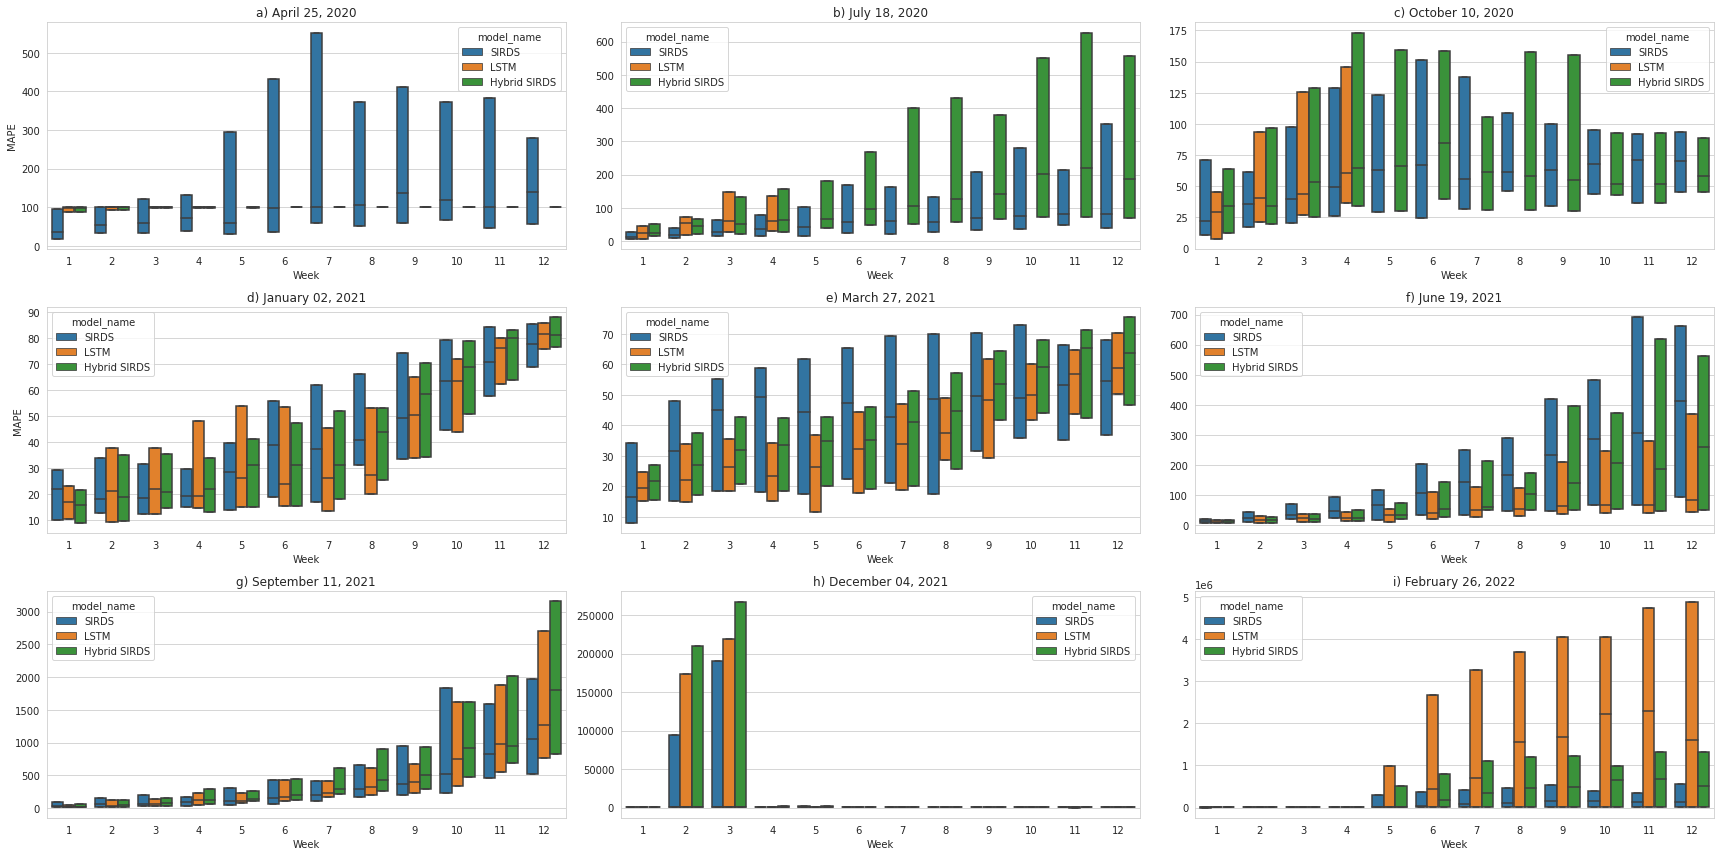

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=False, sharex=False)
i = 0
list_charts = ['a', 'b', 'c', 'd', 'e', 'f','g','h','i']
for max_date_to_fit in df_measurements_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_measurements_chart.loc[(df_measurements_chart['max_date_to_fit']==max_date_to_fit) & (df_measurements_chart['mape']!=np.inf) & (df_measurements_chart['week']!=13)]
    
    sns.boxplot(df_measurements_moment, x='week', y='mape', hue='model_name', showfliers=False, whis=0, ax=ax.flatten()[i])    
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted) 
    
    if (i==0) or (i==3):
        ax.flatten()[i].set_ylabel('MAPE')
    else:
        ax.flatten()[i].set_ylabel(None)
        
    ax.flatten()[i].set_xlabel('Week')

    i += 1

plt.tight_layout()
plt.savefig('images/mape_results.pdf')
plt.show()

### NRMSE

/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning

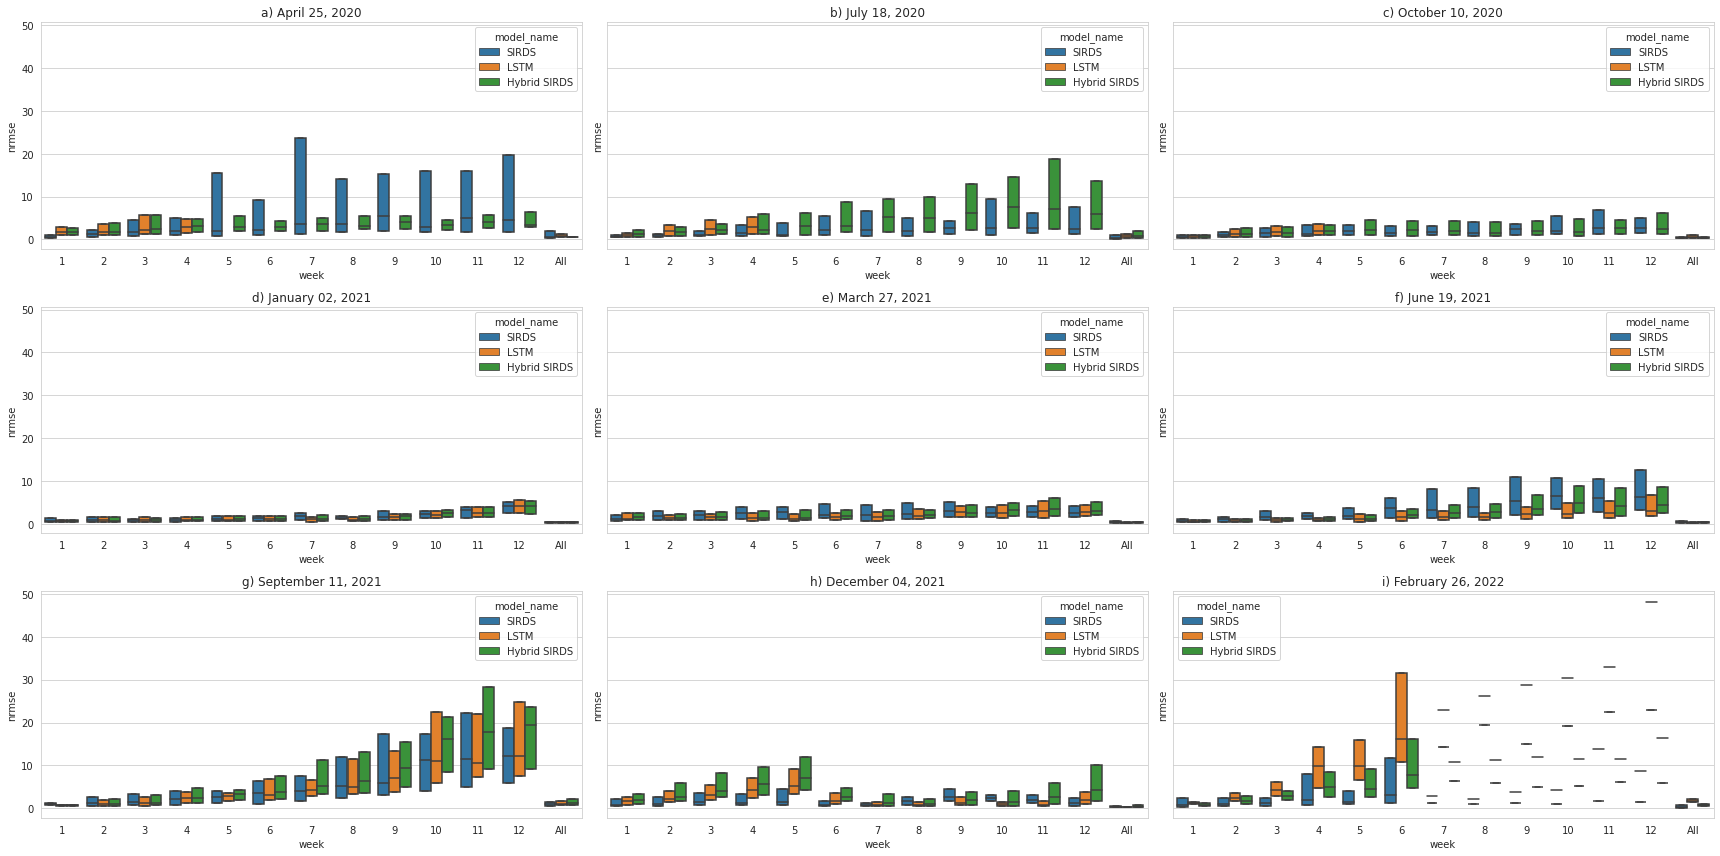

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True)
i = 0

for max_date_to_fit in df_measurements_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_measurements_chart.loc[(df_measurements_chart['max_date_to_fit']==max_date_to_fit)]
    
    sns.boxplot(df_measurements_moment, x='week', y='nrmse', hue='model_name', showfliers=False, whis=0, ax=ax.flatten()[i])    
    xticks = [label.get_text() for label in ax.flatten()[i].get_xticklabels()]
    xticks[-1] = 'All'
    ax.flatten()[i].set_xticklabels(xticks)
    
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted) 
    
    i += 1

plt.tight_layout()
plt.show()

# Analysis acuracy levels

### MAPE

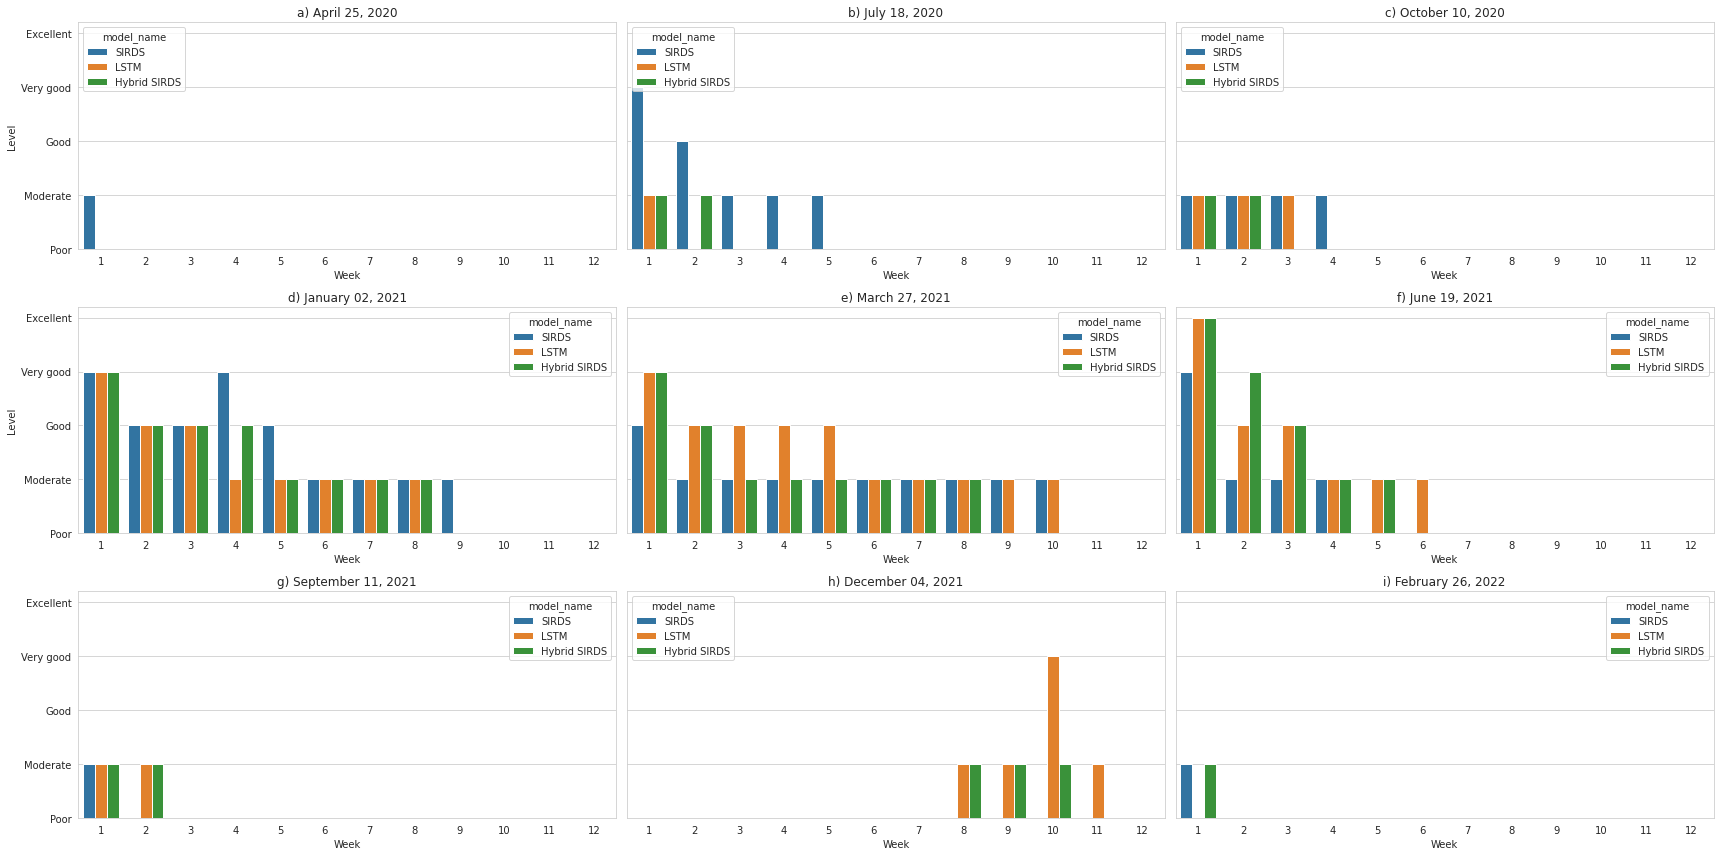

In [25]:
acuracy_level = df_measurements[df_measurements['mape']!=np.inf][['max_date_to_fit','mape','week','model_name']].groupby(['max_date_to_fit','week','model_name']).describe().round(2).reset_index()

acuracy_level.loc[acuracy_level[('mape','50%')]>50, 'level'] = 0
acuracy_level.loc[acuracy_level[('mape','50%')]<=50, 'level'] = 1
acuracy_level.loc[acuracy_level[('mape','75%')]<=40, 'level'] = 2
acuracy_level.loc[acuracy_level[('mape','75%')]<=30, 'level'] = 3
acuracy_level.loc[acuracy_level[('mape','75%')]<=20, 'level'] = 4

acuracy_level.loc[acuracy_level['week']=='all', 'week'] = 13
acuracy_level['week'] = acuracy_level['week'].astype(int)
acuracy_level = acuracy_level.sort_values(by=['max_date_to_fit','model_name'])

acuracy_level.loc[acuracy_level['model_name']=='SIRDS', 'model_order'] = 0
acuracy_level.loc[acuracy_level['model_name']=='LSTM', 'model_order'] = 1
acuracy_level.loc[acuracy_level['model_name']=='Hybrid SIRDS', 'model_order'] = 4
acuracy_level = acuracy_level.sort_values(['max_date_to_fit','model_order'])

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True, sharex=False)
i = 0

for max_date_to_fit in acuracy_level['max_date_to_fit'].unique():
    
    df_measurements_moment = acuracy_level.loc[(acuracy_level['max_date_to_fit']==max_date_to_fit) & (acuracy_level['week']!=13)]
    
    sns.barplot(df_measurements_moment, x='week', y='level', hue='model_name', ax=ax.flatten()[i])    
    # xticks = [label.get_text() for label in ax.flatten()[i].get_xticklabels()]
    # xticks[-1] = 'All'
    # ax.flatten()[i].set_xticklabels(xticks)
    
    yticks = [0,1,2,3,4]
    ax.flatten()[i].set_yticks(yticks)
    yticks_labels = ['Poor','Moderate','Good','Very good','Excellent']
    ax.flatten()[i].set_yticklabels(yticks_labels)
    
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted) 
    
    if (i==0) or (i==3):
        ax.flatten()[i].set_ylabel('Level')
    else:
        ax.flatten()[i].set_ylabel(None)
        
    ax.flatten()[i].set_xlabel('Week')    
    
    i += 1

plt.tight_layout()
plt.savefig('images/level_results.pdf')
plt.show()

### NRMSE

/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning

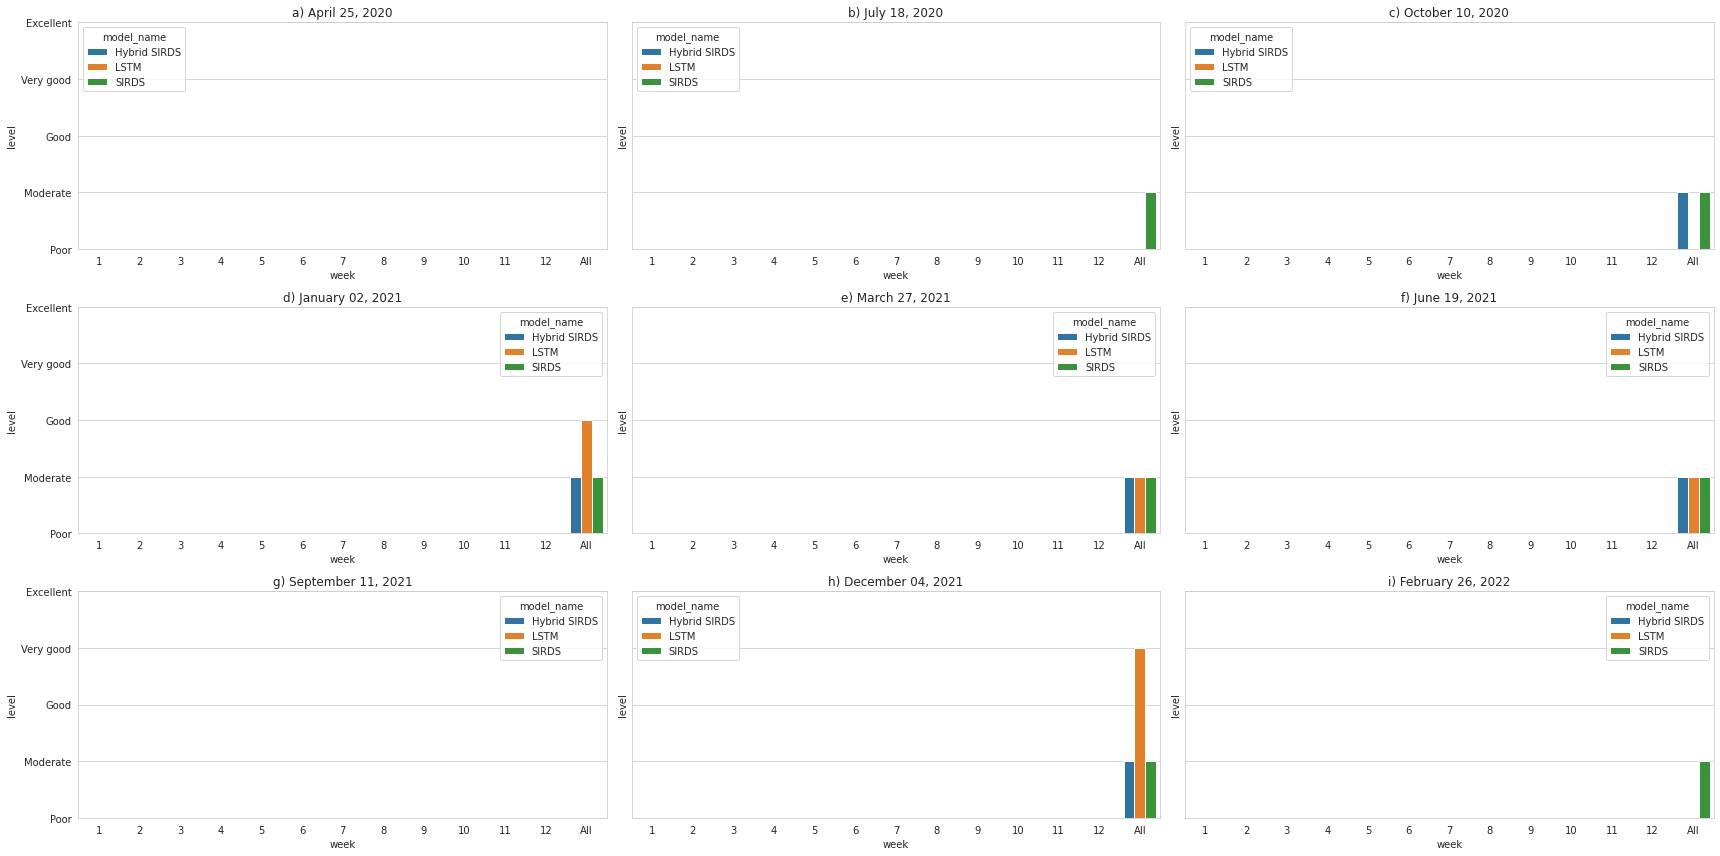

In [26]:
acuracy_level = df_measurements[['max_date_to_fit','nrmse','week','model_name']].groupby(['max_date_to_fit','week','model_name']).describe().round(2).reset_index()

acuracy_level.loc[acuracy_level[('nrmse','50%')]>0.5, 'level'] = 0
acuracy_level.loc[acuracy_level[('nrmse','50%')]<=0.5, 'level'] = 1
acuracy_level.loc[acuracy_level[('nrmse','75%')]<=0.4, 'level'] = 2
acuracy_level.loc[acuracy_level[('nrmse','75%')]<=0.3, 'level'] = 3
acuracy_level.loc[acuracy_level[('nrmse','75%')]<=0.2, 'level'] = 4

acuracy_level.loc[acuracy_level['week']=='all', 'week'] = 13
acuracy_level['week'] = acuracy_level['week'].astype(int)
acuracy_level = acuracy_level.sort_values(by=['max_date_to_fit','model_name'])

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True, sharex=False)
i = 0

for max_date_to_fit in acuracy_level['max_date_to_fit'].unique():
    
    df_measurements_moment = acuracy_level.loc[(acuracy_level['max_date_to_fit']==max_date_to_fit)]
    
    sns.barplot(df_measurements_moment, x='week', y='level', hue='model_name', ax=ax.flatten()[i])    
    xticks = [label.get_text() for label in ax.flatten()[i].get_xticklabels()]
    xticks[-1] = 'All'
    ax.flatten()[i].set_xticklabels(xticks)
    
    yticks = [0,1,2,3,4]
    ax.flatten()[i].set_yticks(yticks)
    yticks_labels = ['Poor','Moderate','Good','Very good','Excellent']
    ax.flatten()[i].set_yticklabels(yticks_labels)
    
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted) 
    
    i += 1

plt.tight_layout()
plt.show()

## Ranking the models

In [27]:
df_measurements_ranking = df_measurements.copy()

In [28]:
df_measurements_median = df_measurements_ranking[df_measurements_ranking['mape']!=np.inf].groupby(['max_date_to_fit','model_name','week'])[['mape']].median().reset_index()

In [29]:
df_measurements_median = df_measurements_median.pivot(index=['max_date_to_fit','week'], columns='model_name', values='mape').reset_index()

In [30]:
df_measurements_median[['rank_SIRDS', 'rank_LSTM', 'rank_Hybrid SIRDS',]] = df_measurements_median[['SIRDS', 'LSTM', 'Hybrid SIRDS']].rank(axis=1)

In [31]:
df_measurements_median

model_name,max_date_to_fit,week,Hybrid SIRDS,LSTM,SIRDS,rank_SIRDS,rank_LSTM,rank_Hybrid SIRDS
0,2020-04-25,1,98.601184,9.864559e+01,34.413801,1.0,3.0,2.0
1,2020-04-25,10,99.987241,NaN,118.557707,2.0,NaN,1.0
2,2020-04-25,11,99.991445,NaN,99.997208,2.0,NaN,1.0
3,2020-04-25,12,99.993999,NaN,140.002615,2.0,NaN,1.0
4,2020-04-25,2,99.565414,9.917260e+01,52.647189,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...
112,2022-02-26,6,170532.401170,4.491279e+05,28359.662763,1.0,3.0,2.0
113,2022-02-26,7,349391.329757,7.078732e+05,91332.400062,1.0,3.0,2.0
114,2022-02-26,8,473379.437859,1.566686e+06,97466.684853,1.0,3.0,2.0
115,2022-02-26,9,489750.150700,1.668402e+06,160509.269071,1.0,3.0,2.0


In [32]:
from scipy.stats import wilcoxon

def test_wilcoxon(model1_mape, model2_mape):
    _, p_value = wilcoxon(model1_mape, model2_mape)
    if p_value < 0.05:
        significant_difference = True
    else:
        significant_difference = False
    return significant_difference

for index, row in df_measurements_median.iterrows():
    max_date_to_fit = row['max_date_to_fit']
    week = row['week']
    
    df_mape = df_measurements_ranking[(df_measurements_ranking['mape']!=np.inf) & (df_measurements_ranking['max_date_to_fit']==max_date_to_fit) & (df_measurements_ranking['week']==week)]    
    
    values = row[['SIRDS', 'LSTM', 'Hybrid SIRDS']].values
    # Create a sorted list of tuples containing the model name and its value
    sorted_values = sorted(zip(['SIRDS', 'LSTM', 'Hybrid SIRDS'], values), key=lambda x: x[1])
    # Extract the sorted model names from the list of tuples
    sorted_models = [model for model, _ in sorted_values]
    print(sorted_models)
    
    previous_position = 1
    count_ranked_models = 1
    for i in range(1, len(sorted_models)):
        previous_model = sorted_models[i-1]
        current_model = sorted_models[i]
        df_previous_and_current_places = df_mape[(df_mape['model_name'].isin([previous_model, current_model]))]
        list_municipalities_in_both = df_previous_and_current_places.pivot(index='municipality', columns='model_name', values='mape').reset_index().dropna()['municipality'].values
        mape_previous_place = df_mape[(df_mape['model_name'] == previous_model) & (df_mape['municipality'].isin(list_municipalities_in_both))]['mape'].values
        mape_current_place = df_mape[(df_mape['model_name'] == current_model) & (df_mape['municipality'].isin(list_municipalities_in_both))]['mape'].values
        if len(mape_current_place) > 0:
            count_ranked_models += 1
            if (len(mape_current_place)==len(mape_previous_place)) and (test_wilcoxon(mape_previous_place, mape_current_place) ==  False):                
                current_position = previous_position                            
            else:
                current_position = count_ranked_models                
            df_measurements_median.at[index, 'rank_'+sorted_models[i]] = current_position
        else:
            df_measurements_median.at[index, 'rank_'+sorted_models[i]] = 0
            current_position =  previous_position
        previous_position = current_position

['SIRDS', 'Hybrid SIRDS', 'LSTM']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'Hybrid SIRDS', 'LSTM']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['LSTM', 'Hybrid SIRDS', 'SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'Hybrid SIRDS', 'LSTM']
['SIRDS', 'Hybrid SIRDS', 'LSTM']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LSTM', 'Hybrid SIRDS']
['SIRDS', 'LST

In [33]:
df_mape

,municipality,week,sse,r2,mape,nrmse,max_date_to_fit,model_name
0,Aparecida de Goiânia,all,0.798228,-49.376868,4.023763e+06,5.498874,2022-02-26,SIRDS
13,Aracaju,all,0.001133,0.698886,5.482024e+04,0.157830,2022-02-26,SIRDS
26,Belo Horizonte,all,0.001049,0.669139,1.221130e+04,0.111689,2022-02-26,SIRDS
39,Belém,all,0.000625,0.722518,2.119913e+04,0.099177,2022-02-26,SIRDS
52,Brasília,all,0.002593,-5.486793,2.241149e+04,0.182589,2022-02-26,SIRDS
...,...,...,...,...,...,...,...,...
468,São José dos Campos,all,0.023524,-13.730111,7.096705e+05,0.575982,2022-02-26,Hybrid SIRDS
481,São Luís,all,0.122827,-3.205017,2.492669e+06,4.243228,2022-02-26,Hybrid SIRDS
494,São Paulo,all,0.025355,-1218.681981,1.367453e+03,1.329580,2022-02-26,Hybrid SIRDS
507,Teresina,all,0.038699,-913.364467,9.886120e+05,1.084478,2022-02-26,Hybrid SIRDS


In [34]:
df_measurements_ranking_updated = df_measurements_median[['max_date_to_fit','week','rank_SIRDS','rank_LSTM', 'rank_Hybrid SIRDS']]
df_measurements_ranking_updated = pd.melt(df_measurements_ranking_updated, 
                            id_vars=['max_date_to_fit', 'week'], 
                            value_vars=['rank_SIRDS','rank_LSTM','rank_Hybrid SIRDS'],
                            var_name='model_name',
                            value_name='rank_value')

In [35]:
df_measurements_ranking_updated = df_measurements_ranking_updated.fillna(0) 

In [36]:
df_measurements_ranking_updated.loc[df_measurements_ranking_updated['week']=='all', 'week'] = 13
df_measurements_ranking_updated['week'] = df_measurements_ranking_updated['week'].astype(int)
df_measurements_ranking_updated = df_measurements_ranking_updated.sort_values(by=['max_date_to_fit','model_name'])

In [37]:
df_measurements_ranking_chart = df_measurements_ranking_updated.copy()

In [38]:
max_rank = 5 + 1 # 5 is the number of columns
df_measurements_ranking_chart.loc[df_measurements_ranking_chart['rank_value']>0, 'rank_value'] = max_rank - df_measurements_ranking_chart.loc[df_measurements_ranking_chart['rank_value']>0, 'rank_value']

In [39]:
df_measurements_ranking_chart.loc[df_measurements_ranking_chart['model_name']=='rank_SIRDS', 'model_order'] = 0
df_measurements_ranking_chart.loc[df_measurements_ranking_chart['model_name']=='rank_LSTM', 'model_order'] = 1
df_measurements_ranking_chart.loc[df_measurements_ranking_chart['model_name']=='rank_Hybrid SIRDS', 'model_order'] = 4
df_measurements_ranking_chart = df_measurements_ranking_chart.sort_values(['max_date_to_fit','model_order'])

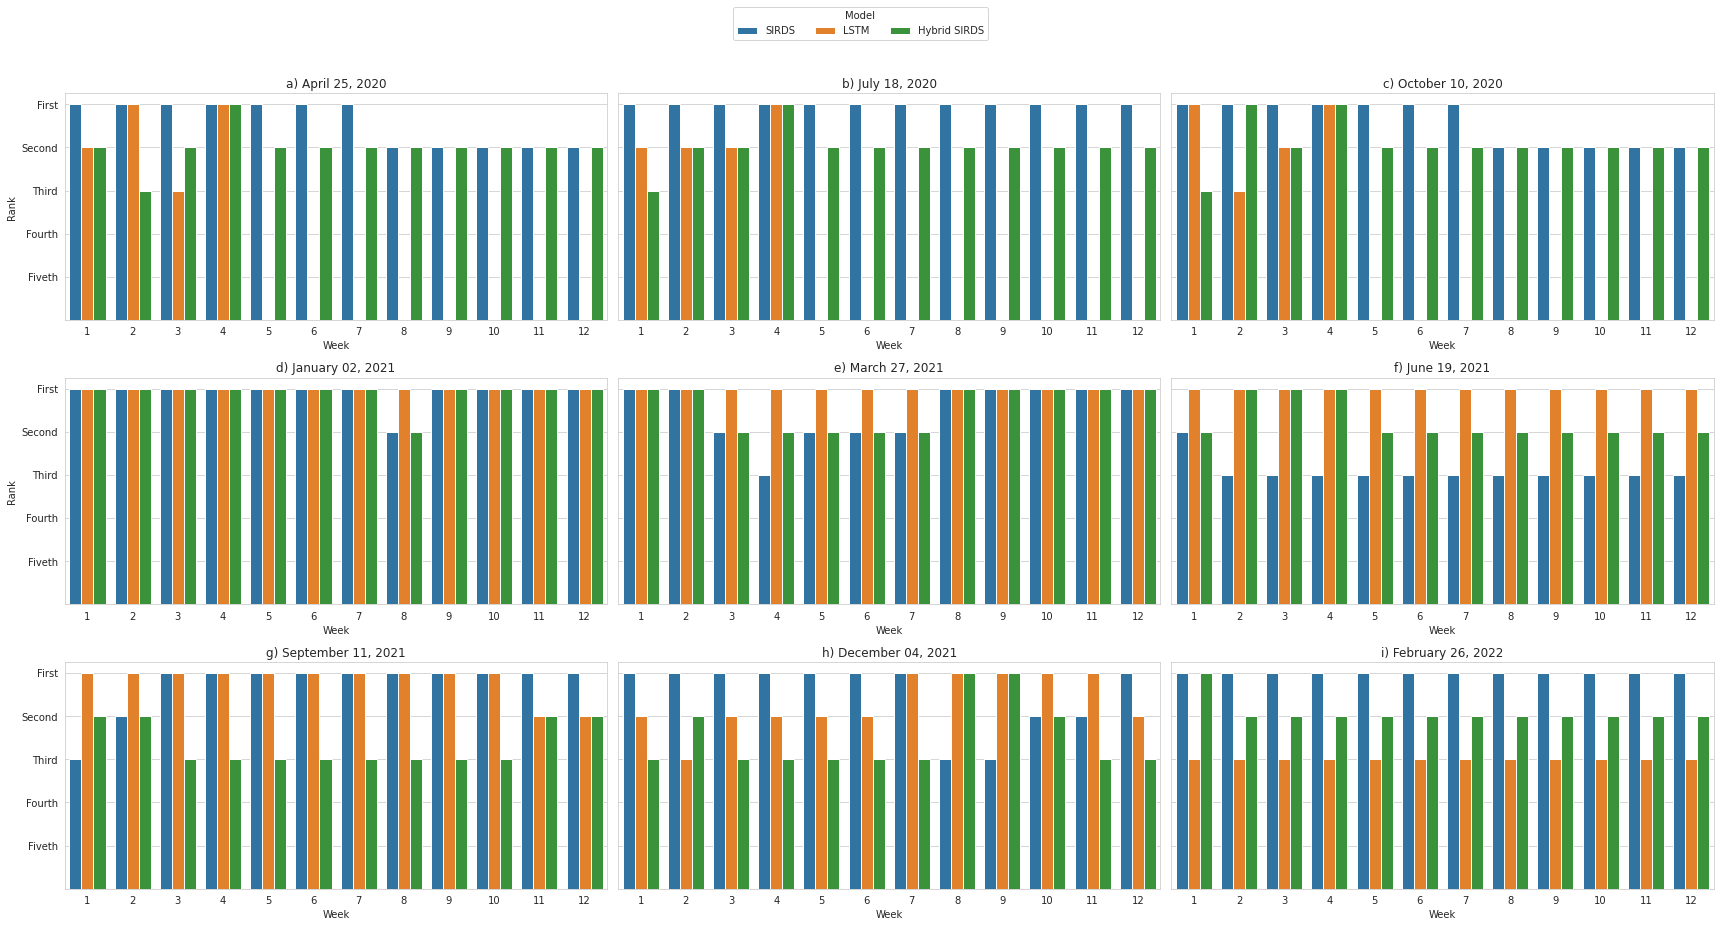

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True, sharex=False)
i = 0
handles, labels = None, None
for max_date_to_fit in df_measurements_ranking_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_measurements_ranking_chart.loc[(df_measurements_ranking_chart['max_date_to_fit']==max_date_to_fit) & (df_measurements_ranking_chart['week']!=13)]
    
    sns.barplot(df_measurements_moment, x='week', y='rank_value', hue='model_name', ax=ax.flatten()[i])
    
    yticks = [0,1,2,3,4,5]
    ax.flatten()[i].set_yticks(yticks)
    yticks_labels = ['','Fiveth', 'Fourth','Third','Second','First']
    ax.flatten()[i].set_yticklabels(yticks_labels)
    
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted) 
    
    if i == 0:
        handles, labels = ax.flatten()[i].get_legend_handles_labels()  # Get handles and labels for the legend    
        
    ax.flatten()[i].legend().remove()  # Remove legend from individual subplot
    
    if (i==0) or (i==3):
        ax.flatten()[i].set_ylabel('Rank')
    else:
        ax.flatten()[i].set_ylabel(None)
        
    ax.flatten()[i].set_xlabel('Week')    
    
    i += 1

fig.legend(handles, ['SIRDS', 'LSTM', 'Hybrid SIRDS'], loc='upper center', bbox_to_anchor=(0.5, 1.075), title='Model', ncols=5)  # Place legend outside of the charts

plt.tight_layout()
plt.savefig('images/rank_results.pdf', bbox_inches='tight')
plt.show()

## Confidence Interval (CI) Coverage analysis
Confidence interval analysis (actual points falling in forecasted confidence interval)

In [41]:
points_falling_in_confidence_interval = pd.DataFrame()

for model_name, df_model_output in zip(['SIRDS', 'LSTM','Hybrid SIRDS'], [df_confidence_interval_sirds, df_confidence_interval_lstm, df_confidence_interval_sirds_hybrid]):
    df_model_output = df_model_output.sort_values(['municipality', 'date'])
    for max_date_to_fit in df_model_output['max_date_to_fit'].unique():        
        list_municipality = []
        list_week = []
        list_count_points_falling_in_confidence_interval = []        
        df_results_moment = df_model_output.loc[(df_model_output['max_date_to_fit'] == max_date_to_fit)]
        for id_municipality in df_results_moment['municipality_id'].unique()[:]:        
            df_results_municipality = df_results_moment.loc[(df_results_moment['municipality_id'] == id_municipality)]
            lower_bound = df_results_municipality['lower_bound'].values
            upper_bound = df_results_municipality['upper_bound'].values
            municipality = df_results_municipality['municipality'].iloc[0]            
            max_date_predicted = df_results_municipality['date'].max()
            
            df_municipality = df.loc[(df.CODIGO_MUNICIPIO_6 == id_municipality)].copy().reset_index(drop=True)
            df_temp = df_municipality.loc[(df_municipality.DATA > max_date_to_fit) & (df_municipality.DATA <= max_date_predicted)]
            real_new_deaths = df_temp.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.values
               
            real_new_deaths_forecasting = real_new_deaths
            model_lower_bound = lower_bound
            model_upper_bound = upper_bound
                                                           
            count_points_falling_in_confidence_interval = len(real_new_deaths_forecasting[(real_new_deaths_forecasting>=model_lower_bound) & (real_new_deaths_forecasting<=model_upper_bound)])
            
            list_municipality.append(municipality)
            list_week.append('all')
            list_count_points_falling_in_confidence_interval.append(count_points_falling_in_confidence_interval)
            
            for week in range(int(len(model_lower_bound)/7)):
                begin = week * 7
                end = (week+1) * 7 
                
                model_lower_bound = lower_bound[begin:end]
                model_upper_bound = upper_bound[begin:end]
                real_new_deaths_forecasting = real_new_deaths[begin:end]
            
                count_points_falling_in_confidence_interval = len(real_new_deaths_forecasting[(real_new_deaths_forecasting>=model_lower_bound) & (real_new_deaths_forecasting<=model_upper_bound)])
            
                list_municipality.append(municipality)
                list_week.append(str(week+1))
                list_count_points_falling_in_confidence_interval.append(count_points_falling_in_confidence_interval)
        
        points_falling_in_confidence_interval_moment = pd.DataFrame({'municipality': list_municipality, 'week': list_week, 'count_points_falling_in_confidence_interval': list_count_points_falling_in_confidence_interval})
        points_falling_in_confidence_interval_moment['max_date_to_fit'] = max_date_to_fit
        points_falling_in_confidence_interval_moment['model_name'] = model_name
        points_falling_in_confidence_interval = pd.concat([points_falling_in_confidence_interval, points_falling_in_confidence_interval_moment])

In [42]:
df_points_falling_in_confidence_interval_chart = points_falling_in_confidence_interval.copy()
df_points_falling_in_confidence_interval_chart.loc[df_points_falling_in_confidence_interval_chart['week']=='all', 'week'] = 13
df_points_falling_in_confidence_interval_chart['week'] = df_points_falling_in_confidence_interval_chart['week'].astype(int)
df_points_falling_in_confidence_interval_chart = df_points_falling_in_confidence_interval_chart.sort_values(by=['max_date_to_fit','model_name'])

In [43]:
df_points_falling_in_confidence_interval_chart.loc[df_points_falling_in_confidence_interval_chart['model_name']=='SIRDS', 'model_order'] = 0
df_points_falling_in_confidence_interval_chart.loc[df_points_falling_in_confidence_interval_chart['model_name']=='LSTM', 'model_order'] = 1
df_points_falling_in_confidence_interval_chart.loc[df_points_falling_in_confidence_interval_chart['model_name']=='Hybrid SIRDS', 'model_order'] = 4
df_points_falling_in_confidence_interval_chart = df_points_falling_in_confidence_interval_chart.sort_values(['max_date_to_fit','model_order'])

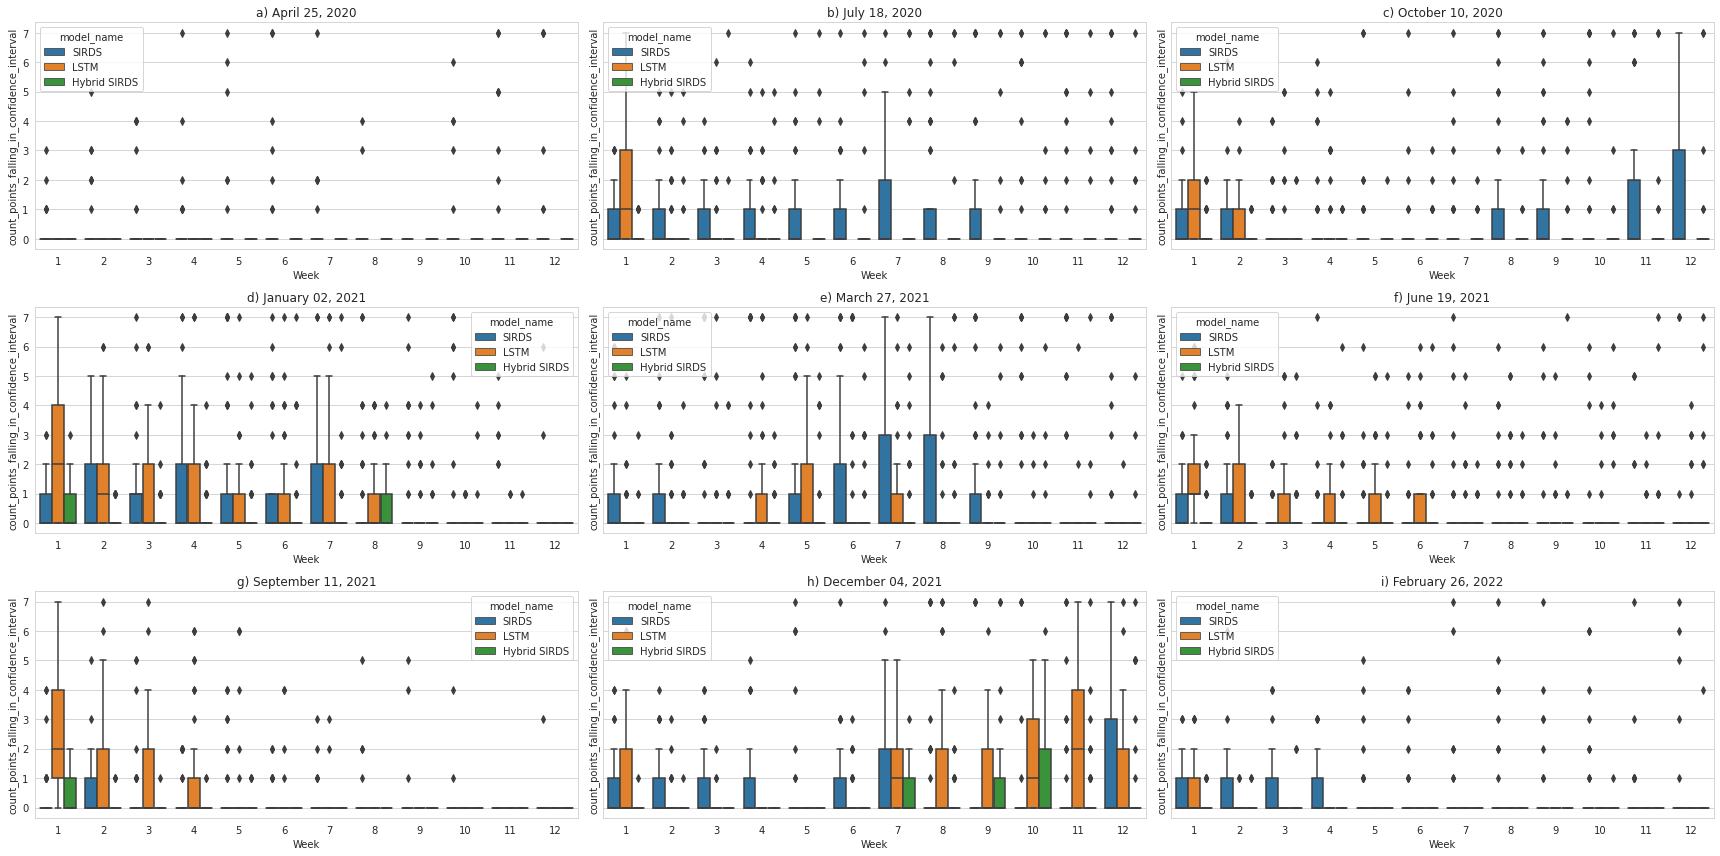

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True, sharex=False)
i = 0

for max_date_to_fit in df_points_falling_in_confidence_interval_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_points_falling_in_confidence_interval_chart.loc[(df_points_falling_in_confidence_interval_chart['max_date_to_fit']==max_date_to_fit) & (df_points_falling_in_confidence_interval_chart['week']!=13)]
    
    sns.boxplot(df_measurements_moment, x='week', y='count_points_falling_in_confidence_interval', hue='model_name', showfliers=True, whis=1.5, ax=ax.flatten()[i])        
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted)    
        
    ax.flatten()[i].set_xlabel('Week')

    i += 1

plt.tight_layout()
plt.show()

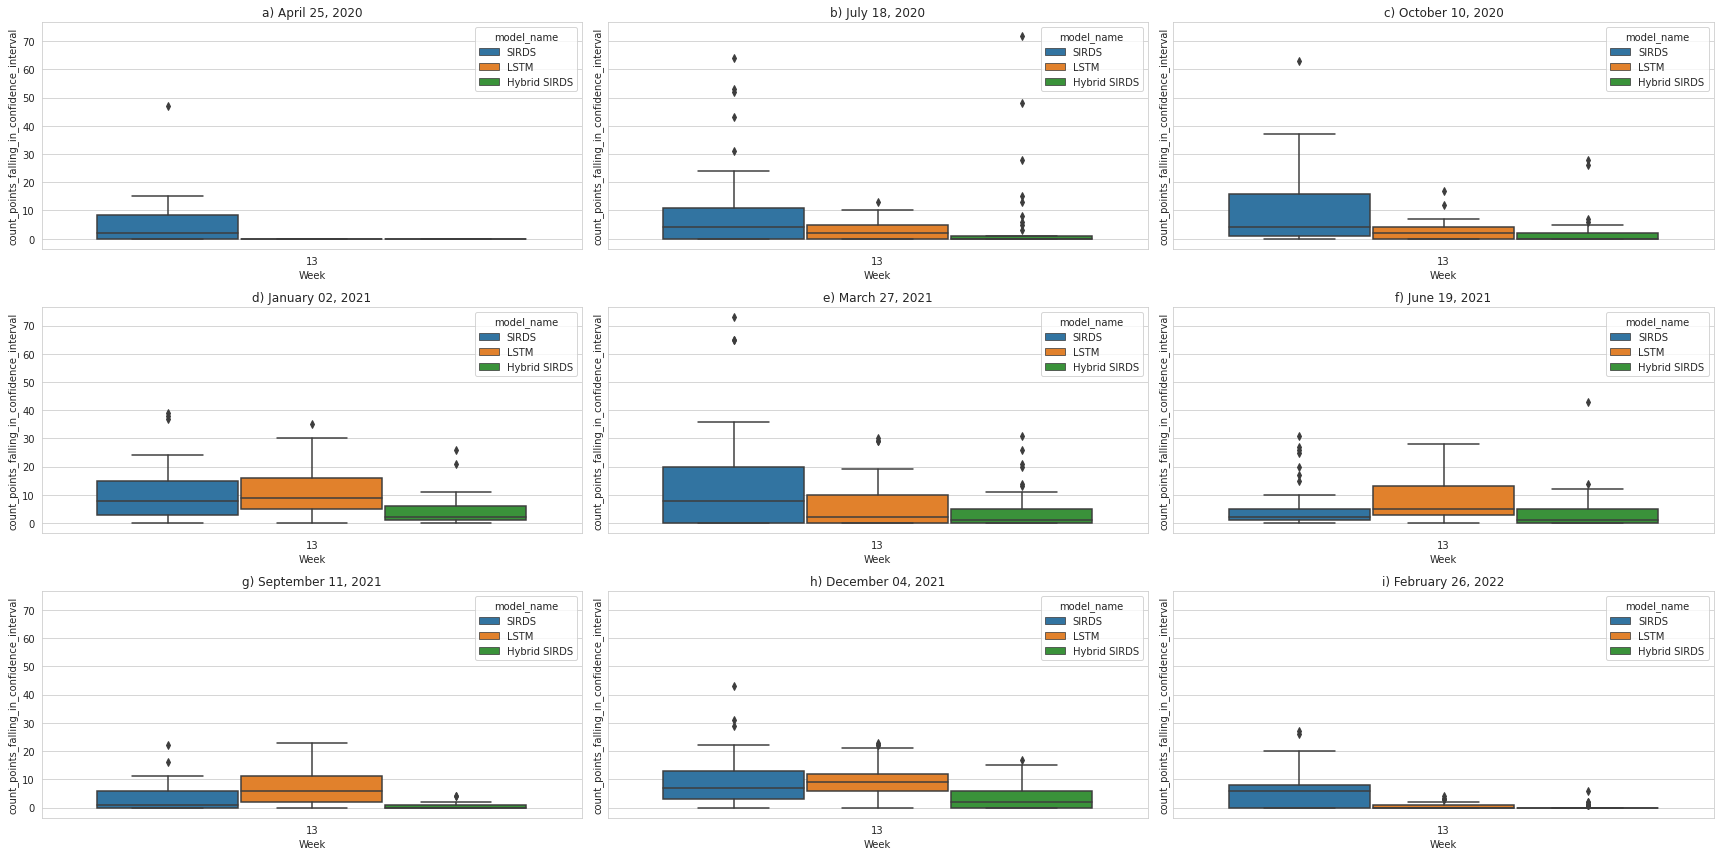

In [45]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True, sharex=False)
i = 0
for max_date_to_fit in df_points_falling_in_confidence_interval_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_points_falling_in_confidence_interval_chart.loc[(df_points_falling_in_confidence_interval_chart['max_date_to_fit']==max_date_to_fit) & (df_points_falling_in_confidence_interval_chart['week']==13)]
    
    sns.boxplot(df_measurements_moment, x='week', y='count_points_falling_in_confidence_interval', hue='model_name', showfliers=True, whis=1.5, ax=ax.flatten()[i])        
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted)    
        
    ax.flatten()[i].set_xlabel('Week')

    i += 1

plt.tight_layout()
plt.show()

<ipython-input-46-851da2fa5078>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_measurements_moment.loc[(df_measurements_moment['week']>=1) & (df_measurements_moment['week']<=4), 'grouped_week'] = '1-4'
<ipython-input-46-851da2fa5078>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_measurements_moment.loc[(df_measurements_moment['week']>=1) & (df_measurements_moment['week']<=4), 'grouped_week'] = '1-4'
<ipython-input-46-851da2fa5078>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy 

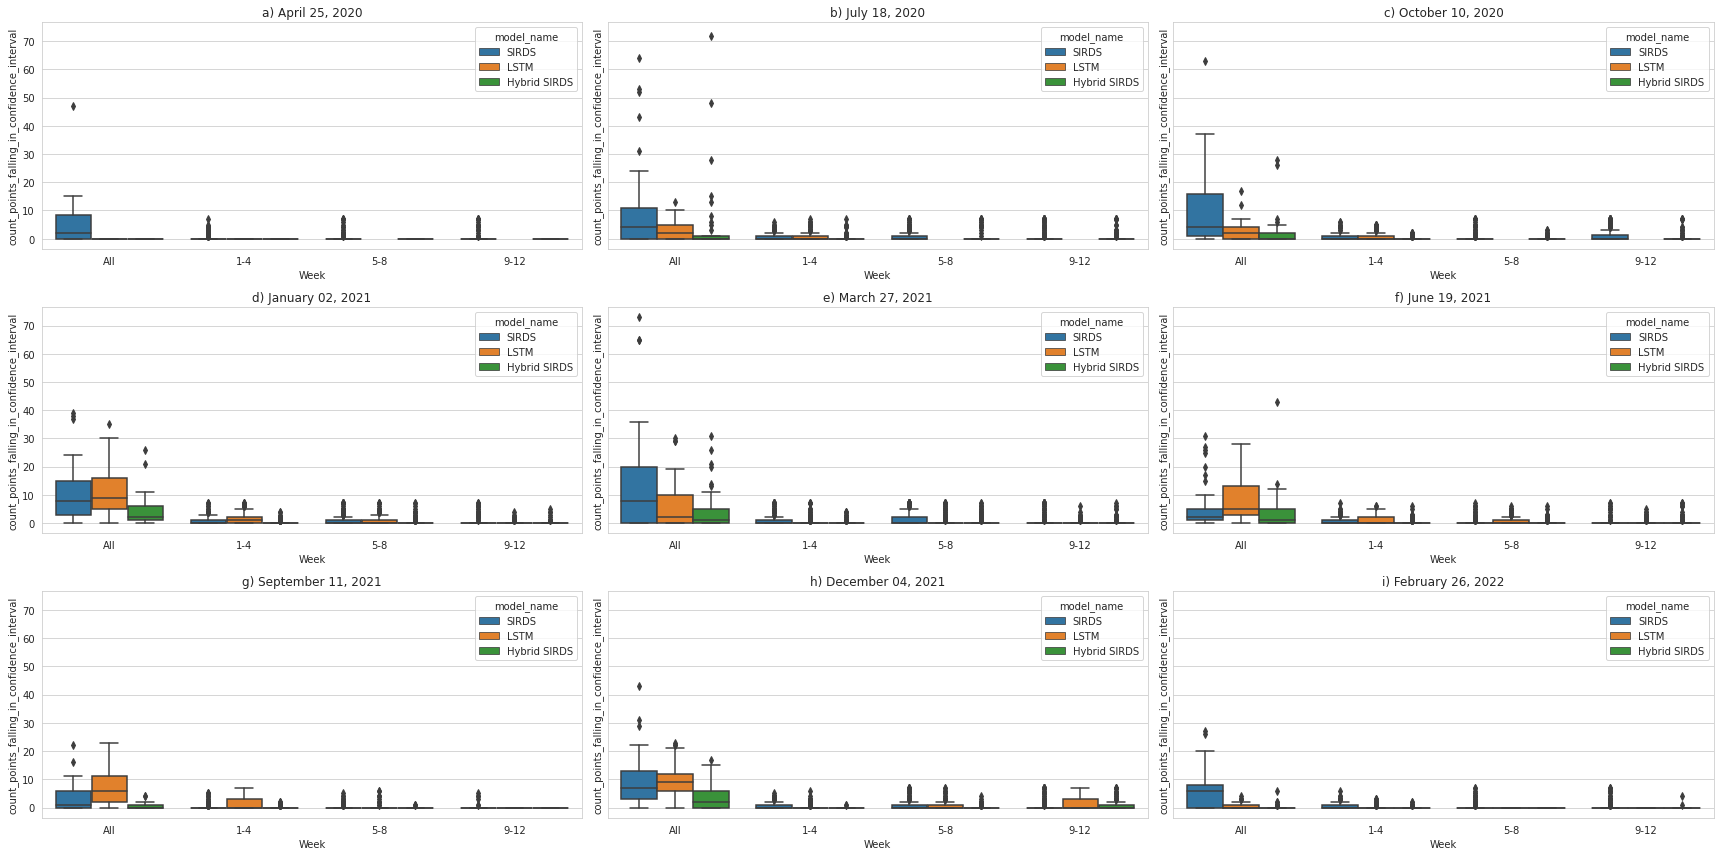

In [46]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True, sharex=False)
i = 0

for max_date_to_fit in df_points_falling_in_confidence_interval_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_points_falling_in_confidence_interval_chart.loc[(df_points_falling_in_confidence_interval_chart['max_date_to_fit']==max_date_to_fit)]
    
    df_measurements_moment.loc[(df_measurements_moment['week']>=1) & (df_measurements_moment['week']<=4), 'grouped_week'] = '1-4'
    df_measurements_moment.loc[(df_measurements_moment['week']>=5) & (df_measurements_moment['week']<=8), 'grouped_week'] = '5-8'
    df_measurements_moment.loc[(df_measurements_moment['week']>=9) & (df_measurements_moment['week']<=12), 'grouped_week'] = '9-12'
    df_measurements_moment.loc[(df_measurements_moment['week']==13), 'grouped_week'] = 'All'
    
    sns.boxplot(df_measurements_moment, x='grouped_week', y='count_points_falling_in_confidence_interval', hue='model_name', showfliers=True, whis=1.5, ax=ax.flatten()[i])        
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted)    
        
    ax.flatten()[i].set_xlabel('Week')

    i += 1

plt.tight_layout()
plt.show()

In [47]:
df_points_falling_in_confidence_interval_chart.columns

Index(['municipality', 'week', 'count_points_falling_in_confidence_interval',
       'max_date_to_fit', 'model_name', 'model_order'],
      dtype='object')

<ipython-input-48-7193cb69ebac>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_measurements_moment.loc[(df_measurements_moment['week']>=1) & (df_measurements_moment['week']<=4), 'grouped_week'] = '1-4'
<ipython-input-48-7193cb69ebac>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_measurements_moment.loc[(df_measurements_moment['week']>=1) & (df_measurements_moment['week']<=4), 'grouped_week'] = '1-4'
<ipython-input-48-7193cb69ebac>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy 

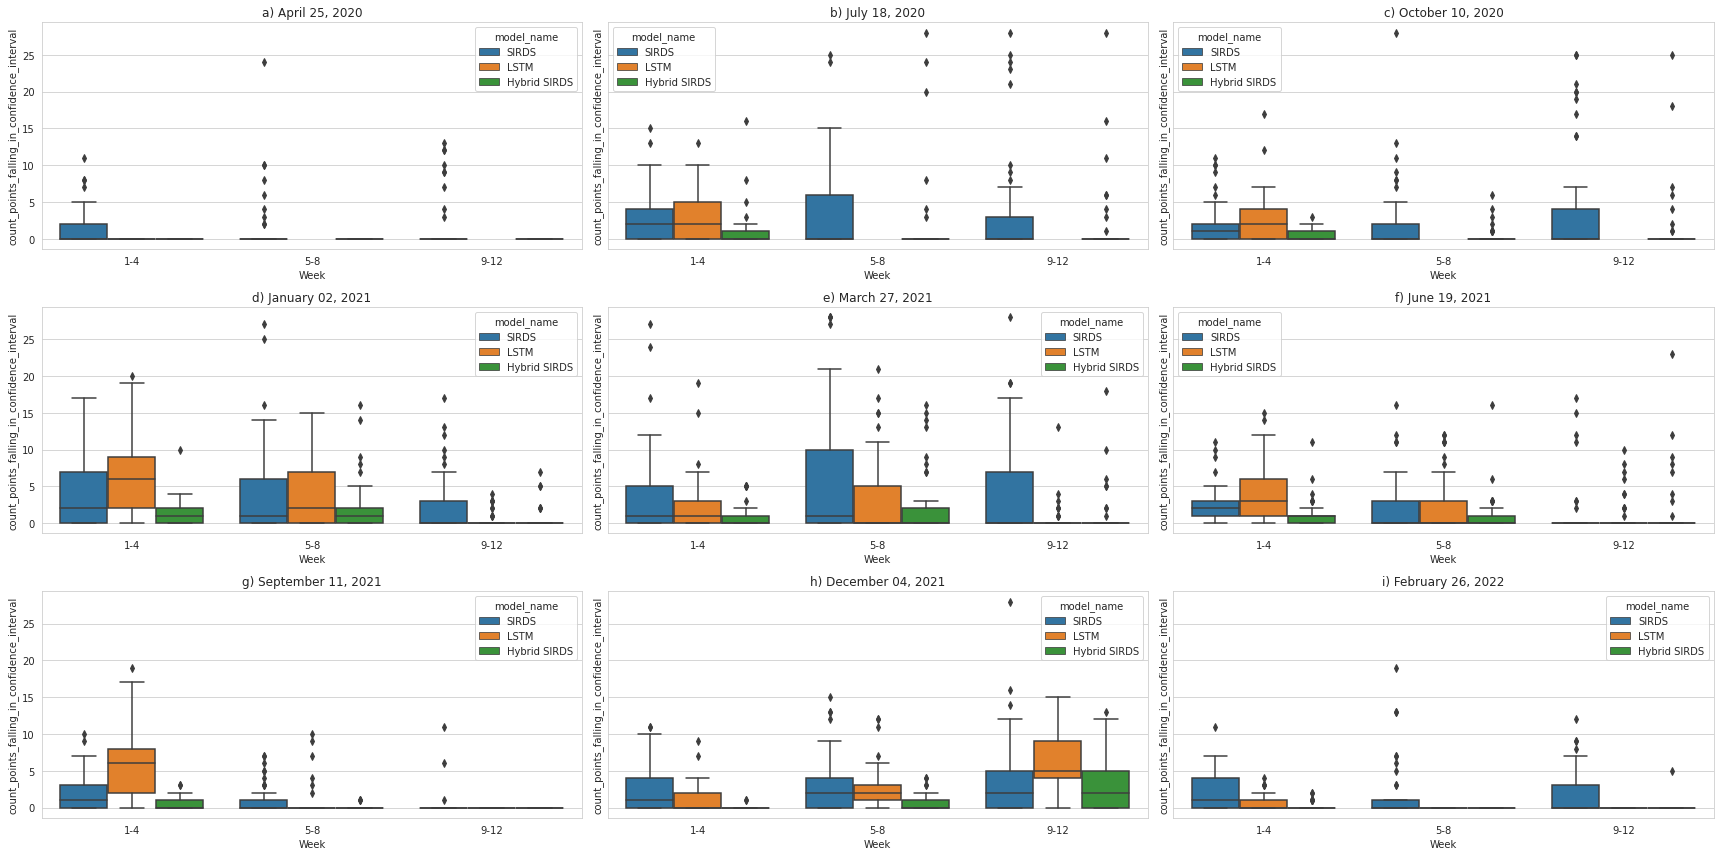

In [48]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12), sharey=True, sharex=False)
i = 0

for max_date_to_fit in df_points_falling_in_confidence_interval_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_points_falling_in_confidence_interval_chart.loc[(df_points_falling_in_confidence_interval_chart['max_date_to_fit']==max_date_to_fit) & (df_points_falling_in_confidence_interval_chart['week']!=13)]
    
    df_measurements_moment.loc[(df_measurements_moment['week']>=1) & (df_measurements_moment['week']<=4), 'grouped_week'] = '1-4'
    df_measurements_moment.loc[(df_measurements_moment['week']>=5) & (df_measurements_moment['week']<=8), 'grouped_week'] = '5-8'
    df_measurements_moment.loc[(df_measurements_moment['week']>=9) & (df_measurements_moment['week']<=12), 'grouped_week'] = '9-12'  
    
    df_measurements_moment = df_measurements_moment.groupby(['municipality', 'model_name','max_date_to_fit', 'model_order', 'grouped_week']).sum().reset_index()
    df_measurements_moment = df_measurements_moment.sort_values(['max_date_to_fit', 'model_order'])
    
    sns.boxplot(df_measurements_moment, x='grouped_week', y='count_points_falling_in_confidence_interval', hue='model_name', showfliers=True, whis=1.5, ax=ax.flatten()[i])        
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted)    
        
    ax.flatten()[i].set_xlabel('Week')

    i += 1

plt.tight_layout()
plt.show()

## Percentual Erros per group of weeks

In [49]:
df_model_output['max_date_to_fit'].unique()

<DatetimeArray>
['2020-07-18 00:00:00', '2020-10-10 00:00:00', '2021-01-02 00:00:00',
 '2021-03-27 00:00:00', '2021-06-19 00:00:00', '2021-09-11 00:00:00',
 '2021-12-04 00:00:00', '2022-02-26 00:00:00', '2020-04-25 00:00:00']
Length: 9, dtype: datetime64[ns]

In [50]:
df_measurements = pd.DataFrame()

noise = 0.000001

for model_name, df_model_output in zip(['Fuzzy SIRDS','LSTM','Hybrid SIRDS', 'Ensemble'], [df_results_sirds, df_results_lstm, df_results_sirds_hybrid, df_results_ensemble]):
    df_model_output = df_model_output.sort_values(['municipality', 'date'])
    for max_date_to_fit in df_model_output['max_date_to_fit'].unique():
        list_municipality = []
        list_period = []
        list_ape = []
        list_mape = []
        list_smape = []
        df_results_moment = df_model_output.loc[(df_model_output['max_date_to_fit'] == max_date_to_fit)]
        for id_municipality in df_results_moment['municipality_id'].unique():        
            df_results_municipality = df_results_moment.loc[(df_results_moment['municipality_id'] == id_municipality)]
            model_new_deaths = df_results_municipality['forecast'].values
            municipality = df_results_municipality['municipality'].iloc[0]
            max_date_predicted = df_results_municipality['date'].max()
            
            df_municipality = df[(df.CODIGO_MUNICIPIO_6 == id_municipality)].copy().reset_index(drop=True)
            df_temp = df_municipality[(df_municipality.DATA > max_date_to_fit) & (df_municipality.DATA <= max_date_predicted)]
            real_new_deaths = df_temp.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.values
            
            real_new_deaths_forecasting = real_new_deaths
            model_new_deaths_forecasting = model_new_deaths
            
            if (max_date_to_fit >= df_model_output['max_date_to_fit'].unique()[3]) or (model_name != 'LSTM'):                                               
                ape = np.abs((np.sum(real_new_deaths_forecasting) - np.sum(model_new_deaths_forecasting)) / (np.sum(real_new_deaths_forecasting) + noise)) * 100
                mape = np.mean(np.abs((real_new_deaths_forecasting - model_new_deaths_forecasting) / (real_new_deaths_forecasting + EPSILON))) * 100
                smape = np.mean(2 * np.abs(real_new_deaths_forecasting - model_new_deaths_forecasting) / 
                (np.abs(real_new_deaths_forecasting) + np.abs(model_new_deaths_forecasting) + EPSILON)) * 100

                list_municipality.append(municipality)
                list_period.append('all')            
                list_ape.append(ape)
                list_mape.append(mape)
                list_smape.append(smape)

            for period in range(int(len(model_new_deaths)/28)):
                begin = period * 28
                end = (period+1) * 28 
                
                model_new_deaths_forecasting = model_new_deaths[begin:end]
                real_new_deaths_forecasting = real_new_deaths[begin:end]
            
                ape = np.abs((np.sum(real_new_deaths_forecasting) - np.sum(model_new_deaths_forecasting)) / (np.sum(real_new_deaths_forecasting) + noise)) * 100
                mape = np.mean(np.abs((real_new_deaths_forecasting - model_new_deaths_forecasting) / (real_new_deaths_forecasting + EPSILON))) * 100
                smape = np.mean(2 * np.abs(real_new_deaths_forecasting - model_new_deaths_forecasting) / 
                (np.abs(real_new_deaths_forecasting) + np.abs(model_new_deaths_forecasting) + EPSILON)) * 100
            
                list_municipality.append(municipality)
                list_period.append(str(period+1))
                list_ape.append(ape)
                list_mape.append(mape)
                list_smape.append(smape)
        
        df_measurements_moment = pd.DataFrame({'municipality': list_municipality, 'period': list_period, 'ape': list_ape, 'mape': list_mape, 'smape': list_smape})
        df_measurements_moment['max_date_to_fit'] = max_date_to_fit
        df_measurements_moment['model_name'] = model_name
        df_measurements = pd.concat([df_measurements, df_measurements_moment])

In [51]:
df_measurements_chart = df_measurements.copy()
df_measurements_chart.loc[df_measurements_chart['period']=='all', 'period'] = 13
df_measurements_chart['week'] = df_measurements_chart['period'].astype(int)
df_measurements_chart = df_measurements_chart.sort_values(by=['max_date_to_fit','model_name'])

In [52]:
df_measurements_chart.loc[df_measurements_chart['model_name']=='Fuzzy SIRDS', 'model_order'] = 0
df_measurements_chart.loc[df_measurements_chart['model_name']=='LSTM', 'model_order'] = 1
df_measurements_chart.loc[df_measurements_chart['model_name']=='Hybrid SIRDS', 'model_order'] = 2
df_measurements_chart.loc[df_measurements_chart['model_name']=='Hybrid LSTM', 'model_order'] = 3
df_measurements_chart.loc[df_measurements_chart['model_name']=='Ensemble', 'model_order'] = 4
df_measurements_chart = df_measurements_chart.sort_values(['max_date_to_fit','model_order'])

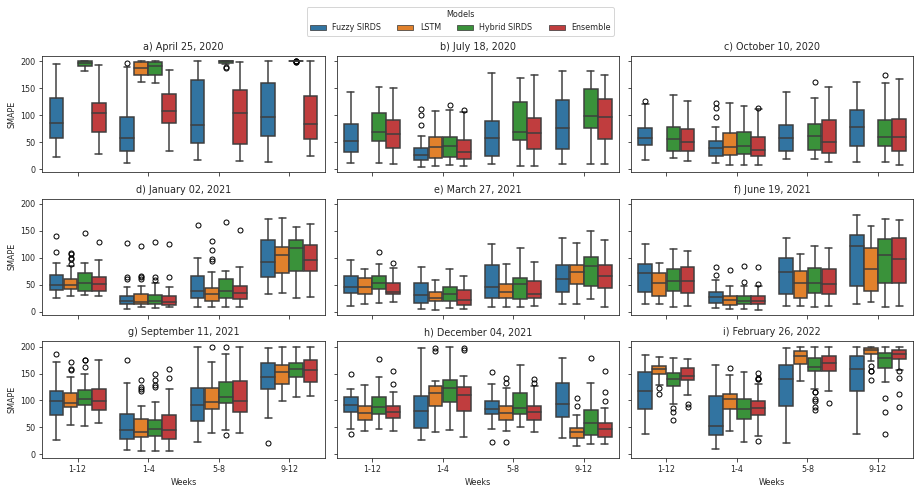

In [53]:
def plot_boxplots(df, column_statistic):
    plt.rc('font', size=8)
    sns.set_style("ticks")    
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12.825,6.42), sharey=True, sharex=False)
    i = 0
    
    for max_date_to_fit in df['max_date_to_fit'].unique():
        
        df_measurements_moment = df.loc[(df['max_date_to_fit']==max_date_to_fit) & (df[column_statistic]!=np.inf)]
        
        sns.boxplot(df_measurements_moment, x='period', y=column_statistic, hue='model_name', 
                    showfliers=True, whis=1.5, 
                    flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='black'), 
                    ax=ax.flatten()[i])    
        
        max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
        ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted) 
        
        ax.flatten()[i].set_ylabel(str.upper(column_statistic))
    
        if i >= 6:
            ax.flatten()[i].set_xlabel('Weeks')
            ax.flatten()[i].set_xticklabels(['1-12', '1-4', '5-8', '9-12']) 
        else:
            ax.flatten()[i].set_xlabel(None)
            ax.flatten()[i].set_xticklabels([])
        
        if i in [0,3,6]:
            ax.flatten()[i].set_ylabel('SMAPE')
        else:
            ax.flatten()[i].set_ylabel(None)

        i += 1

    # Add a single legend at the top of the figure
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.065), title='Models')
    
    # Remove individual legends
    for a in ax.flatten():
        a.legend_.remove()
        
    plt.tight_layout()
    fig.savefig('images/'+column_statistic+'.pdf', bbox_inches='tight')
    plt.show()

plot_boxplots(df_measurements_chart, 'smape')

In [54]:
df_measurements_chart[(df_measurements_chart['period']=='1')].groupby(['max_date_to_fit','model_name'])['smape'].median()

max_date_to_fit  model_name  
2020-04-25       Ensemble        108.013749
                 Fuzzy SIRDS      56.728386
                 Hybrid SIRDS    190.359396
                 LSTM            186.932376
2020-07-18       Ensemble         31.629320
                 Fuzzy SIRDS      26.762053
                 Hybrid SIRDS     41.917001
                 LSTM             41.667779
2020-10-10       Ensemble         35.467063
                 Fuzzy SIRDS      39.391097
                 Hybrid SIRDS     43.362963
                 LSTM             41.192867
2021-01-02       Ensemble         18.514367
                 Fuzzy SIRDS      20.776833
                 Hybrid SIRDS     19.207640
                 LSTM             18.894287
2021-03-27       Ensemble         22.098850
                 Fuzzy SIRDS      31.845802
                 Hybrid SIRDS     32.476438
                 LSTM             25.771394
2021-06-19       Ensemble         19.160708
                 Fuzzy SIRDS      27.937492
  

In [55]:
df_measurements_chart[(df_measurements_chart['period']==13) & (df_measurements_chart['max_date_to_fit']=='2021-03-27')].groupby('model_name')['smape'].median()

model_name
Ensemble        37.408011
Fuzzy SIRDS     45.359701
Hybrid SIRDS    53.864657
LSTM            45.088870
Name: smape, dtype: float64

In [56]:
df_measurements_chart['max_date_to_fit'].unique()

<DatetimeArray>
['2020-04-25 00:00:00', '2020-07-18 00:00:00', '2020-10-10 00:00:00',
 '2021-01-02 00:00:00', '2021-03-27 00:00:00', '2021-06-19 00:00:00',
 '2021-09-11 00:00:00', '2021-12-04 00:00:00', '2022-02-26 00:00:00']
Length: 9, dtype: datetime64[ns]

In [57]:
df_measurements_chart[['max_date_to_fit','period','model_name','mape']].groupby(['max_date_to_fit','period','model_name']).median()

mape
max_date_to_fit period model_name                
2020-04-25      13     Ensemble      1.463886e+02
                       Fuzzy SIRDS   1.568462e+02
                       Hybrid SIRDS  9.985511e+01
                1      Ensemble      7.940930e+01
                       Fuzzy SIRDS   5.589073e+01
...                                           ...
2022-02-26      2      LSTM          1.260349e+06
                3      Ensemble      1.118184e+06
                       Fuzzy SIRDS   2.408345e+05
                       Hybrid SIRDS  6.535470e+05
                       LSTM          2.102437e+06

[135 rows x 1 columns]

## Heatmap chart per municipality and analysis moment

In [58]:
df_municipality_population = df[['MUNICIPIO','POPULACAO_2022']].drop_duplicates()
df_municipality_population.columns = ['municipality','population']
df_municipality_population_selected = df_municipality_population.sort_values('population', ascending=False)[:20]

In [59]:
df_measurements_chart_selected = df_measurements_chart.loc[(df_measurements_chart['municipality'].isin(df_municipality_population_selected['municipality']))]

In [60]:
# Define function to format colorbar ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0f}%'

def plot_hotmap(df_measurements, df_population, name_file, fig_height = 7, fig_width=7.75):
    plt.rc('font', size=8)
    sns.set_style("ticks")
    
    colors = ["blue", "yellow", "red"]
    n_bins = 100  # Number of bins
    cmap_name = "blue_yellow_red"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    for model_name in df_measurements['model_name'].unique():
        print(model_name)
        df_measurements_chart_model = df_measurements.loc[(df_measurements['model_name']==model_name)]
        df_measurements_chart_model = df_measurements_chart_model.merge(df_population, how='left', on='municipality')
        
        # Get unique periods
        periods = [13, 1, 2, 3]    
        period_labels = ['a) 1-12 weeks', 'b) 1-4 weeks', 'c) 5-8 weeks', 'd) 9-12 weeks']
        
        vmin = 0
        vmax = 200
        
        # Set up the figure and axes
        fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height), sharex=True, sharey=True)
        
        # Flatten axes array for easy iteration
        axes = axes.flatten()
        
        # Track the first heatmap for colorbar reference
        first_heatmap = None
        
        for i, period in enumerate(periods):
            title = period_labels[i]
            # Filter data for the current period
            df_period = df_measurements_chart_model[df_measurements_chart_model['week'] == period].copy()
    
            # Pivot data for the heatmap
            heatmap_data = df_period.pivot_table(index="municipality", columns="max_date_to_fit", values="smape")
            if (model_name == 'LSTM') and (period in [13,2,3]):
                heatmap_data[df_measurements_chart['max_date_to_fit'].unique()[0]] = np.nan
                heatmap_data[df_measurements_chart['max_date_to_fit'].unique()[1]] = np.nan
                heatmap_data[df_measurements_chart['max_date_to_fit'].unique()[2]] = np.nan
                        
            sorted_columns = heatmap_data.columns.sort_values()
            heatmap_data = heatmap_data[sorted_columns]
        
            formatted_dates = heatmap_data.columns.strftime('%m/%d/%Y').tolist()
        
            population_order = df_population.set_index('municipality').loc[heatmap_data.index]['population'].sort_values(ascending=False).index
            heatmap_data = heatmap_data.reindex(index=population_order)
        
            # Plot heatmap
            ax = axes[i]    
            heatmap = sns.heatmap(heatmap_data, annot=False, cmap=custom_cmap, fmt=".1f", ax=ax, vmin=vmin, vmax=vmax, cbar=False) 
                    
            # Track the first heatmap to use for the colorbar
            if first_heatmap is None:
                first_heatmap = heatmap
        
            # Set x-axis labels
            ax.set_xticklabels(formatted_dates, rotation=90, ha='right')
                
            # Set titles and labels
            ax.set_title(title)
            if i >= 2:
                ax.set_xlabel('Forecast date')
            else:
                ax.set_xlabel(None)
            ax.set_ylabel(None)
        
        # Create a single colorbar
        cbar_ax = fig.add_axes([0.15, 0.92, 0.7, 0.02])  # Adjust position and size as needed
        cbar = plt.colorbar(first_heatmap.get_children()[0], cax=cbar_ax, orientation='horizontal')
        cbar.set_label('SMAPE')
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format colorbar ticks as percentages
        
        # Adjust layout manually
        plt.subplots_adjust(top=0.825, bottom=0.15, left=0.125, right=0.975, hspace=0.125, wspace=0.1)  # Adjust these values as needed
        
        plt.savefig('images/heatmap_'+name_file+'_'+model_name+'.pdf')
        plt.savefig('images/heatmap_'+name_file+'_'+model_name+'.png')
        
        plt.show()

Fuzzy SIRDS


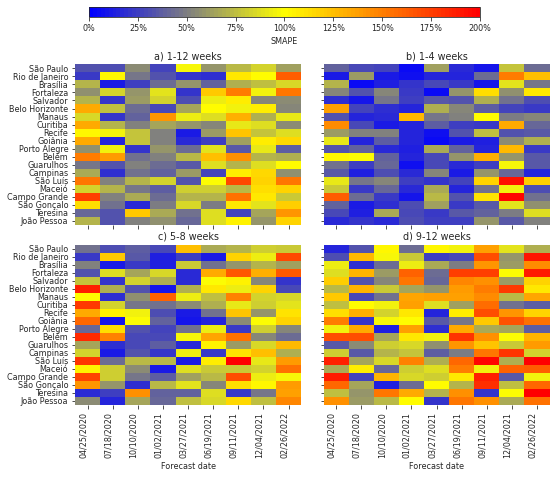

LSTM


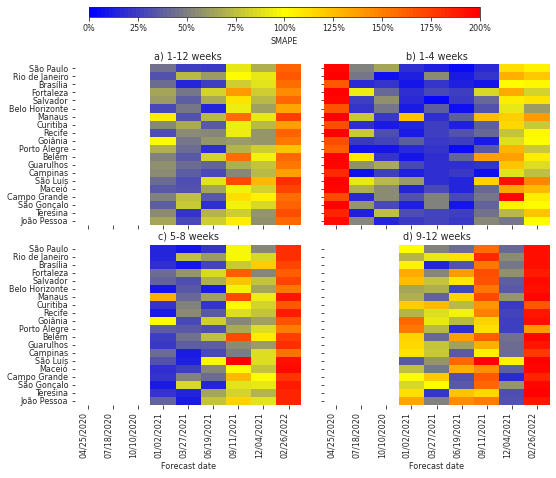

Hybrid SIRDS


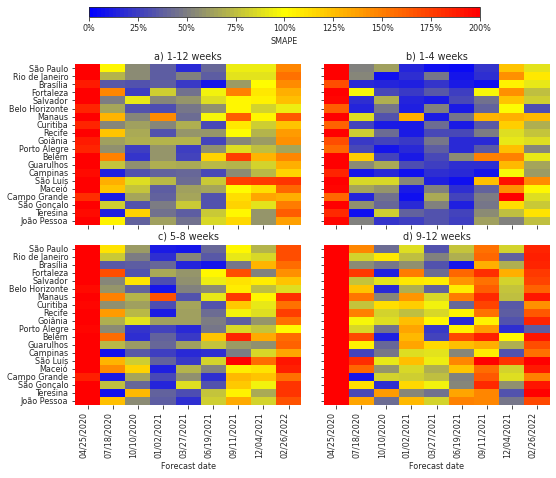

Ensemble


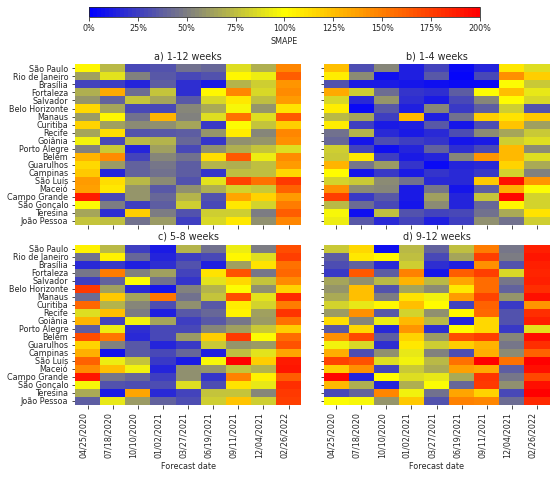

In [61]:
plot_hotmap(df_measurements_chart_selected, df_municipality_population_selected, 'selected')

Fuzzy SIRDS


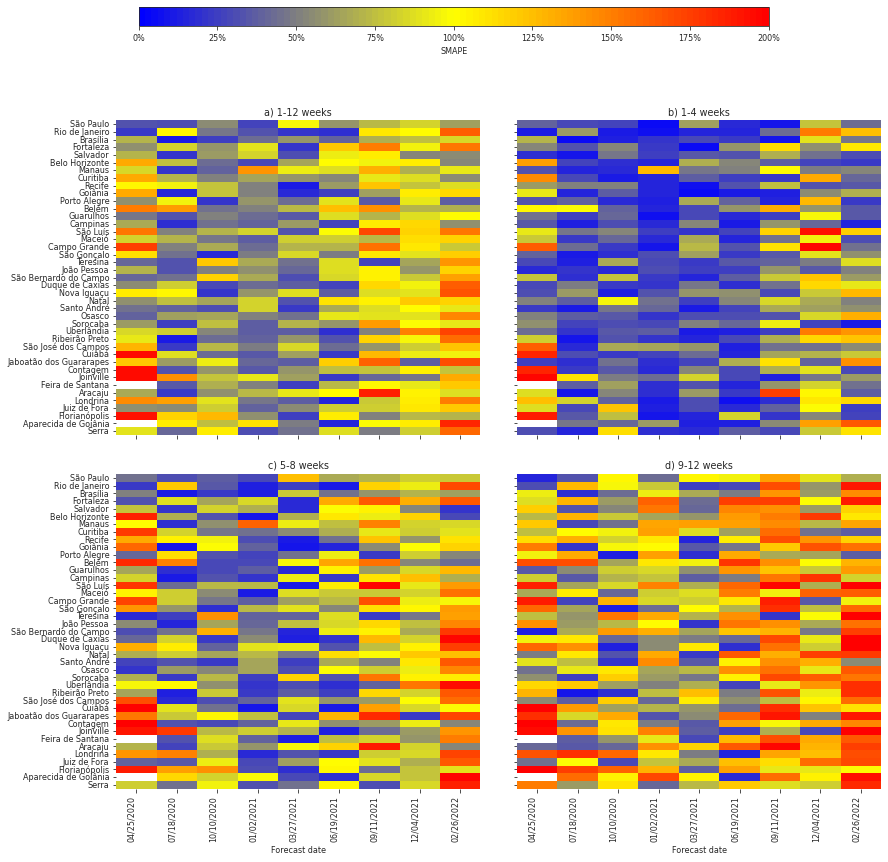

LSTM


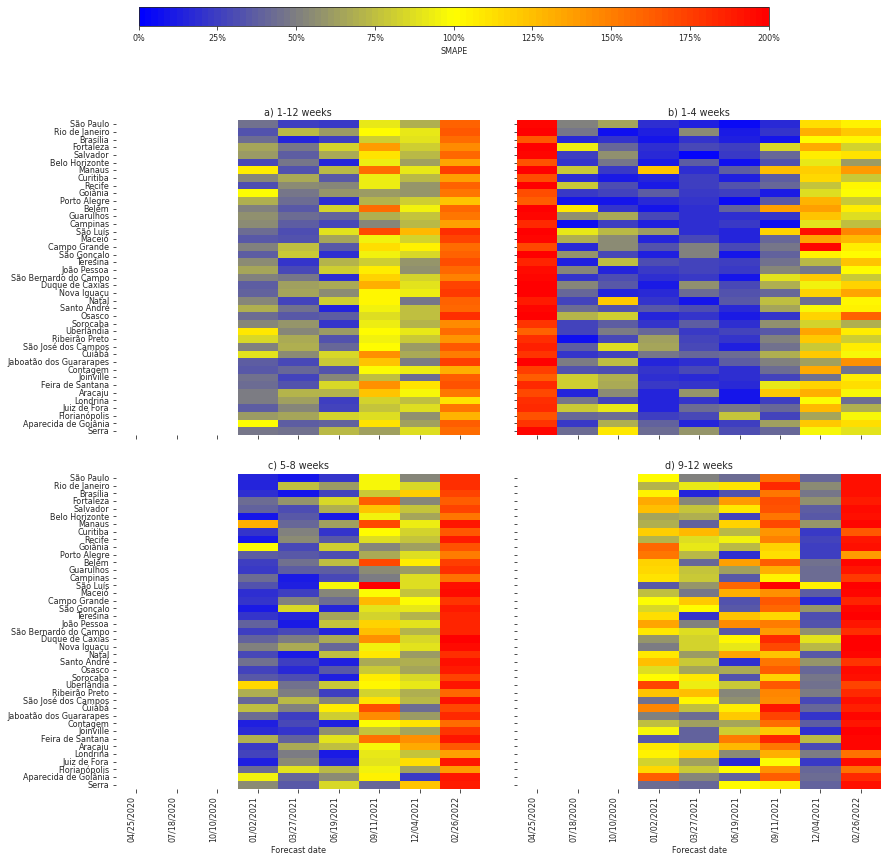

Hybrid SIRDS


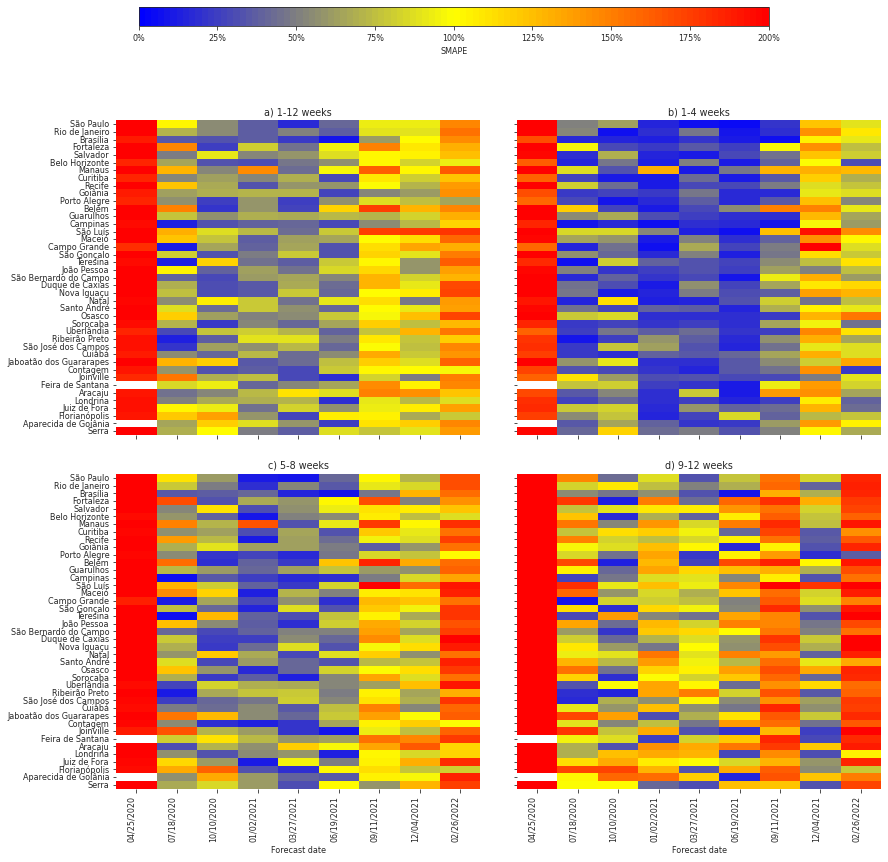

Ensemble


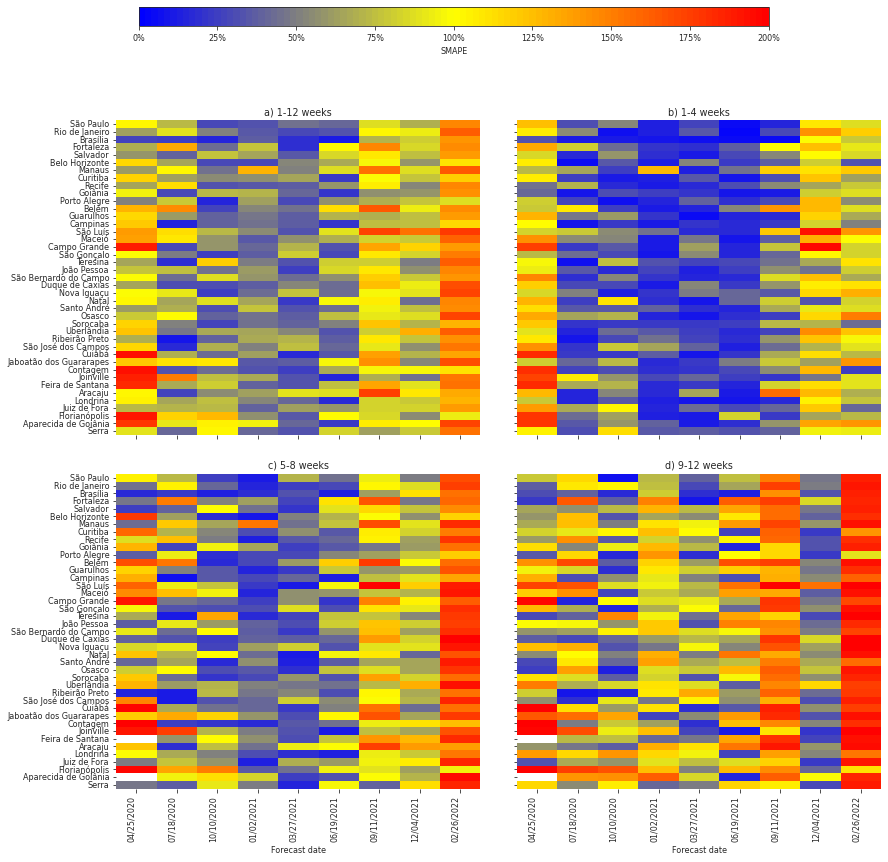

In [62]:
plot_hotmap(df_measurements_chart, df_municipality_population, 'all', fig_height=13.75,fig_width=12.5)

## Best forecast

In [63]:
df_best_forecast = df_measurements_chart.drop(columns=['week','model_order'])
df_best_forecast.columns

Index(['municipality', 'period', 'ape', 'mape', 'smape', 'max_date_to_fit',
       'model_name'],
      dtype='object')

In [64]:
df_best_forecast = df_best_forecast.pivot_table(index=['municipality', 'period', 'max_date_to_fit'],
                          columns=['model_name'],
                          values='smape',
                          aggfunc='first').reset_index()
df_best_forecast.columns.name = None

In [65]:
model_columns = ['Hybrid SIRDS', 'LSTM', 'Fuzzy SIRDS', 'Ensemble']

# Find the column with the lowest value for each row
df_best_forecast['best_model'] = df_best_forecast[model_columns].idxmin(axis=1)

In [66]:
df_best_forecast

,municipality,period,max_date_to_fit,Ensemble,Fuzzy SIRDS,Hybrid SIRDS,LSTM,best_model
0,Aparecida de Goiânia,13,2020-04-25,179.131778,NaN,NaN,NaN,Ensemble
1,Aparecida de Goiânia,13,2020-07-18,90.053058,106.942092,65.107155,NaN,Hybrid SIRDS
2,Aparecida de Goiânia,13,2020-10-10,105.059437,75.586096,118.420464,NaN,Fuzzy SIRDS
3,Aparecida de Goiânia,13,2021-01-02,95.389202,110.578438,86.157883,98.704254,Hybrid SIRDS
4,Aparecida de Goiânia,13,2021-03-27,40.445658,48.836225,59.616854,36.331276,LSTM
...,...,...,...,...,...,...,...,...
1467,Uberlândia,3,2021-03-27,87.174260,68.380765,102.288684,93.165597,Fuzzy SIRDS
1468,Uberlândia,3,2021-06-19,37.582778,26.425292,43.209779,78.340943,Fuzzy SIRDS
1469,Uberlândia,3,2021-09-11,146.103407,90.799432,143.289119,165.253550,Fuzzy SIRDS
1470,Uberlândia,3,2021-12-04,114.809387,141.436436,114.262336,44.839400,LSTM


In [67]:
df_best_forecast_chart = df_best_forecast[['period','max_date_to_fit','best_model','municipality']].groupby(['period','max_date_to_fit','best_model']).count().reset_index()
df_best_forecast_chart

,period,max_date_to_fit,best_model,municipality
0,13,2020-04-25,Ensemble,17
1,13,2020-04-25,Fuzzy SIRDS,20
2,13,2020-04-25,Hybrid SIRDS,4
3,13,2020-07-18,Ensemble,4
4,13,2020-07-18,Fuzzy SIRDS,24
...,...,...,...,...
123,3,2021-12-04,Fuzzy SIRDS,2
124,3,2021-12-04,Hybrid SIRDS,8
125,3,2021-12-04,LSTM,23
126,3,2022-02-26,Fuzzy SIRDS,30


In [68]:
df_best_forecast_chart.loc[df_best_forecast_chart['best_model']=='Fuzzy SIRDS', 'model_order'] = 0
df_best_forecast_chart.loc[df_best_forecast_chart['best_model']=='LSTM', 'model_order'] = 1
df_best_forecast_chart.loc[df_best_forecast_chart['best_model']=='Hybrid SIRDS', 'model_order'] = 2
df_best_forecast_chart.loc[df_best_forecast_chart['best_model']=='Hybrid LSTM', 'model_order'] = 3
df_best_forecast_chart.loc[df_best_forecast_chart['best_model']=='Ensemble', 'model_order'] = 4
df_best_forecast_chart = df_best_forecast_chart.sort_values(['max_date_to_fit','model_order'])

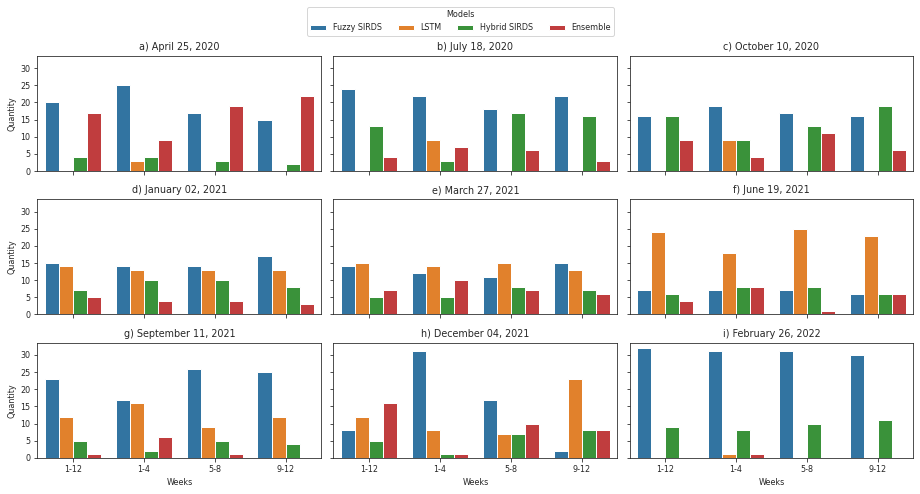

In [69]:
plt.rc('font', size=8)
sns.set_style("ticks")

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12.825,6.42), sharey=True, sharex=False)
i = 0
for max_date_to_fit in df_best_forecast_chart['max_date_to_fit'].unique():
    
    df_measurements_moment = df_best_forecast_chart.loc[(df_best_forecast_chart['max_date_to_fit']==max_date_to_fit)]
    
    sns.barplot(df_measurements_moment, x='period', y='municipality', hue='best_model', ax=ax.flatten()[i])    
    max_date_formatted = datetime.strftime(pd.to_datetime(max_date_to_fit),'%B %d, %Y')
    ax.flatten()[i].set_title(list_charts[i]+') '+max_date_formatted) 
    
    if (i==0) or (i==3) or (i==6):
        ax.flatten()[i].set_ylabel('Quantity')
    else:
        ax.flatten()[i].set_ylabel(None)
        
    if i >= 6:
        ax.flatten()[i].set_xlabel('Weeks')
        ax.flatten()[i].set_xticklabels(['1-12', '1-4', '5-8', '9-12']) 
    else:
        ax.flatten()[i].set_xlabel(None)
        ax.flatten()[i].set_xticklabels([])

    i += 1

# Add a single legend at the top of the figure
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.065), title='Models')

# Remove individual legends
for a in ax.flatten():
    a.legend_.remove()
    
plt.tight_layout()
fig.savefig('images/best_models.pdf', bbox_inches='tight')
plt.show()